# Unsupervised Anomaly Detection (Fraud) Algorithm

We first do some data cleaning (exclusions, imputation), then build variables that are designed to look for the kinds of anomalies we are interested in, in this case, unusual property valuations.

After we build the variables we know we have lots of correlations and too high dimensionality so we need to remove correlations and reduce dimensionality. Since we don't have a dependent variable the easiest useful thing to do is PCA. We z scale, do PCA, keep the top PCs, then z scale again in order to make each retained PC equally important.

We use two different anamaly detection (fraud) algorithms. The first just looks for outliers in the final scaled PC space using a Minkowski distance from the origin. The second method makes a simple autoencoder and the fraud score is then the reproduction error. It's important to note that each/either of these two methods would be a fine fraud score by itself.

Since we have two score and we don't really know which one is better we just average the two scores. To do this we replace the score with its rank order and then average the rank-ordered scores for our final score.

Finally we sort all the records by this final score and explore the top n records. To help the investigation we show which of the variables are driving these top scoring records with a heat map of the variable zscores, which can point the investigators to what's making the high score for these top scoring records.

Future improvements to this project include more interaction with domain experts in order to do proper exclusions and design good/appropriate variables and creating more outstanding features.

The data can be found here: https://data.cityofnewyork.us/Housing-Development/Property-Valuation-and-Assessment-Data/rgy2-tti8

In [3]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 6 seconds

LOAD DURATION: 0:00:02.785178


In [4]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

CPU times: user 3.64 s, sys: 649 ms, total: 4.29 s
Wall time: 4.36 s


(1070994, 32)

In [5]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [6]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


## Remove some benign properties that we aren't interested in
There are certainly better ways to do this, and this important step can/should be improved.

In [7]:
# first look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [8]:
# remove some of these and add some others to also be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS')
remove_list.append('NYC DEPT OF HIGHWAYS')
remove_list.append("NYC DEP'T OF HIGHWAYS")
remove_list.append('CITY WIDE ADMINISTRAT')
remove_list.append('DEPT OF PUBLIC WORKS')
remove_list.append('NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ')
remove_list.append('NYC DEPT OF PUB WORKS')
remove_list.append('NEW YORK STATE DEPART')
remove_list.append('CITY AND NON-CITY OWN')

In [9]:
property_data = data[~data['OWNER'].isin(remove_list)].reset_index(drop=True)
property_data.shape

(1046516, 32)

In [10]:
data.shape

(1070994, 32)

In [11]:
# this is how many records we removed
len(data) - len(property_data)

24478

In [12]:
numrecs = len(property_data)

## Fill in missing ZIP

In [13]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21537

In [14]:
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [15]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

10114

In [16]:
# import module
from geopy.geocoders import Nominatim  
# initialize Nominatim API 
geolocator = Nominatim(user_agent='https://nominatim.openstreetmap.org/search' )

In [17]:
# 286
#len(missing_zips)
#for i in range(len(missing_zips)):
for i in range(len(missing_zips)):
        try:
            # place input by geek
            place = str(property_data.loc[missing_zips[i],'STADDR'])+' New York,'+' USA'
            #print(place)
            location = geolocator.geocode(place)
            # traverse the data
            data = location.raw
            loc_data = data['display_name'].split(', ')
            #print("Full Location")
            #print(loc_data)
            print("Zip code : ",loc_data[-2])
            zip=loc_data[-2]
            len(zip)
            print(len(zip))
            if len(zip)<=5:
                property_data.loc[missing_zips[i],'ZIP'] = loc_data[-2]
                print(i)
            else:
                property_data.loc[missing_zips[i],'ZIP'] = 0
        except:
            pass

Zip code :  10115
5
0
Zip code :  10282
5
1
Zip code :  10282
5
2
Zip code :  10282
5
3
Zip code :  10282
5
4
Zip code :  10282
5
5
Zip code :  10282
5
6
Zip code :  10282
5
7
Zip code :  10282
5
8
Zip code :  10282
5
9
Zip code :  10282
5
10
Zip code :  10282
5
11
Zip code :  10282
5
12
Zip code :  10282
5
13
Zip code :  10282
5
14
Zip code :  10282
5
15
Zip code :  10282
5
16
Zip code :  10282
5
17
Zip code :  10282
5
18
Zip code :  10282
5
19
Zip code :  10282
5
20
Zip code :  10282
5
21
Zip code :  10282
5
22
Zip code :  10282
5
23
Zip code :  10282
5
24
Zip code :  10282
5
25
Zip code :  10282
5
26
Zip code :  10282
5
27
Zip code :  10282
5
28
Zip code :  10282
5
29
Zip code :  10282
5
30
Zip code :  10282
5
31
Zip code :  10282
5
32
Zip code :  10282
5
33
Zip code :  10282
5
34
Zip code :  10282
5
35
Zip code :  10282
5
36
Zip code :  10282
5
37
Zip code :  10282
5
38
Zip code :  10282
5
39
Zip code :  10282
5
40
Zip code :  10282
5
41
Zip code :  10282
5
42
Zip code :  10282
5
4

Zip code :  11435
5
414
Zip code :  11435
5
415
Zip code :  10037
5
419
Zip code :  10027
5
421
Zip code :  10035
5
422
Zip code :  11714
5
423
Zip code :  10454
5
424
Zip code :  11714
5
431
Zip code :  11714
5
432
Zip code :  10035
5
433
Zip code :  10035
5
434
Zip code :  10454
5
435
Zip code :  11714
5
437
Zip code :  11714
5
438
Zip code :  12010
5
439
Zip code :  10027
5
441
Zip code :  10025
5
442
Zip code :  12010
5
443
Zip code :  10040
5
450
Zip code :  10040
5
451
Zip code :  10040
5
454
Zip code :  10040
5
455
Zip code :  10031
5
456
Zip code :  10027
5
457
Zip code :  10040
5
458
Zip code :  10040
5
459
Zip code :  10040
5
460
Zip code :  10040
5
461
Zip code :  10040
5
462
Zip code :  10040
5
463
Zip code :  10040
5
464
Zip code :  10031
5
465
Zip code :  10040
5
466
Zip code :  60505
5
467
Zip code :  10040
5
470
Zip code :  10027
5
474
Zip code :  12010
5
475
Zip code :  12010
5
476
Zip code :  10040
5
477
Zip code :  10034
5
480
Zip code :  10034
5
481
Zip code :  1004

Zip code :  11714
5
932
Zip code :  11714
5
933
Zip code :  11576
5
934
Zip code :  10468
5
935
Zip code :  10452
5
936
Zip code :  10454
5
937
Zip code :  10454
5
938
Zip code :  11714
5
940
Zip code :  11714
5
942
Zip code :  11714
5
943
Zip code :  11714
5
944
Zip code :  11714
5
945
Zip code :  10468
5
946
Zip code :  10468
5
947
Zip code :  10468
5
948
Zip code :  10468
5
949
Zip code :  10468
5
954
Zip code :  10468
5
955
Zip code :  10468
5
956
Zip code :  10463
5
957
Zip code :  10463
5
958
Zip code :  10463
5
959
Zip code :  10463
5
960
Zip code :  10468
5
962
Zip code :  10468
5
963
Zip code :  10463
5
964
Zip code :  10463
5
965
Zip code :  10463
5
966
Zip code :  10463
5
967
Zip code :  10463
5
968
Zip code :  10463
5
969
Zip code :  11714
5
972
Zip code :  10463
5
973
Zip code :  10463
5
975
Zip code :  10463
5
976
Zip code :  10470
5
977
Zip code :  10470
5
978
Zip code :  10468
5
981
Zip code :  10468
5
982
Zip code :  10468
5
983
Zip code :  10468
5
984
Zip code :  1046

Zip code :  10475
5
1329
Zip code :  10475
5
1330
Zip code :  10475
5
1331
Zip code :  10475
5
1332
Zip code :  10475
5
1333
Zip code :  10475
5
1334
Zip code :  10475
5
1335
Zip code :  10475
5
1336
Zip code :  10475
5
1338
Zip code :  10475
5
1339
Zip code :  10475
5
1340
Zip code :  10475
5
1341
Zip code :  10475
5
1342
Zip code :  10475
5
1343
Zip code :  10475
5
1344
Zip code :  14215
5
1345
Zip code :  14215
5
1346
Zip code :  14215
5
1347
Zip code :  14215
5
1348
Zip code :  10475
5
1349
Zip code :  10475
5
1350
Zip code :  10475
5
1351
Zip code :  10475
5
1352
Zip code :  10475
5
1353
Zip code :  10475
5
1354
Zip code :  10475
5
1355
Zip code :  10573
5
1356
Zip code :  10475
5
1357
Zip code :  10475
5
1358
Zip code :  10466
5
1359
Zip code :  10475
5
1360
Zip code :  10475
5
1361
Zip code :  10475
5
1362
Zip code :  10475
5
1363
Zip code :  10475
5
1364
Zip code :  10475
5
1365
Zip code :  10475
5
1366
Zip code :  10475
5
1367
Zip code :  10475
5
1368
Zip code :  10467
5
1369


Zip code :  11231
5
1728
Zip code :  11231
5
1729
Zip code :  11231
5
1730
Zip code :  11231
5
1731
Zip code :  11231
5
1732
Zip code :  11231
5
1733
Zip code :  11231
5
1734
Zip code :  11231
5
1735
Zip code :  11231
5
1736
Zip code :  11231
5
1737
Zip code :  11231
5
1738
Zip code :  11231
5
1739
Zip code :  11231
5
1740
Zip code :  11231
5
1741
Zip code :  11231
5
1742
Zip code :  11231
5
1743
Zip code :  11231
5
1744
Zip code :  11231
5
1745
Zip code :  11231
5
1746
Zip code :  11231
5
1747
Zip code :  11231
5
1748
Zip code :  11231
5
1749
Zip code :  11231
5
1750
Zip code :  11231
5
1751
Zip code :  11231
5
1752
Zip code :  11231
5
1753
Zip code :  11231
5
1754
Zip code :  New York
8
Zip code :  10035
5
1767
Zip code :  10035
5
1768
Zip code :  10035
5
1769
Zip code :  10035
5
1770
Zip code :  10010
5
1774
Zip code :  10459
5
1779
Zip code :  10459
5
1780
Zip code :  12885
5
1787
Zip code :  12885
5
1788
Zip code :  11217
5
1789
Zip code :  11217
5
1790
Zip code :  11217
5
1791
Zi

Zip code :  14701
5
2125
Zip code :  11211
5
2126
Zip code :  11211
5
2127
Zip code :  11211
5
2128
Zip code :  11222
5
2129
Zip code :  11222
5
2130
Zip code :  11222
5
2131
Zip code :  11222
5
2132
Zip code :  11237
5
2133
Zip code :  11211
5
2134
Zip code :  11222
5
2135
Zip code :  11222
5
2136
Zip code :  11222
5
2137
Zip code :  11211
5
2138
Zip code :  11746
5
2139
Zip code :  11211
5
2140
Zip code :  11211
5
2141
Zip code :  11237
5
2142
Zip code :  11237
5
2143
Zip code :  11716
5
2144
Zip code :  11714
5
2145
Zip code :  11716
5
2146
Zip code :  11716
5
2147
Zip code :  10013
5
2148
Zip code :  10013
5
2149
Zip code :  10013
5
2150
Zip code :  11206
5
2151
Zip code :  11207
5
2152
Zip code :  11207
5
2153
Zip code :  11206
5
2154
Zip code :  11206
5
2155
Zip code :  11222
5
2156
Zip code :  New York
8
Zip code :  New York
8
Zip code :  11206
5
2159
Zip code :  11206
5
2160
Zip code :  11206
5
2161
Zip code :  14620
5
2163
Zip code :  14620
5
2164
Zip code :  14620
5
2165
Zip 

Zip code :  11239
5
2459
Zip code :  11239
5
2460
Zip code :  11239
5
2461
Zip code :  11239
5
2462
Zip code :  11239
5
2463
Zip code :  11239
5
2464
Zip code :  11239
5
2465
Zip code :  11239
5
2466
Zip code :  11239
5
2467
Zip code :  11239
5
2468
Zip code :  11239
5
2469
Zip code :  11239
5
2470
Zip code :  11239
5
2471
Zip code :  11239
5
2472
Zip code :  11239
5
2473
Zip code :  11239
5
2474
Zip code :  11239
5
2475
Zip code :  11239
5
2476
Zip code :  11239
5
2477
Zip code :  11239
5
2478
Zip code :  11239
5
2479
Zip code :  11239
5
2480
Zip code :  11239
5
2481
Zip code :  11239
5
2482
Zip code :  11239
5
2483
Zip code :  11239
5
2484
Zip code :  11239
5
2485
Zip code :  11239
5
2486
Zip code :  11239
5
2487
Zip code :  11239
5
2488
Zip code :  11239
5
2489
Zip code :  11239
5
2490
Zip code :  11239
5
2491
Zip code :  11239
5
2492
Zip code :  11239
5
2493
Zip code :  11239
5
2494
Zip code :  11239
5
2495
Zip code :  11239
5
2496
Zip code :  11239
5
2497
Zip code :  11239
5
2498


Zip code :  11235
5
2924
Zip code :  11224
5
2925
Zip code :  11224
5
2926
Zip code :  11224
5
2930
Zip code :  11224
5
2931
Zip code :  11224
5
2933
Zip code :  11207
5
2935
Zip code :  11224
5
2939
Zip code :  11224
5
2940
Zip code :  11224
5
2941
Zip code :  New York
8
Zip code :  11789
5
2943
Zip code :  11789
5
2944
Zip code :  11789
5
2945
Zip code :  New York
8
Zip code :  New York
8
Zip code :  11224
5
2953
Zip code :  11224
5
2954
Zip code :  11224
5
2955
Zip code :  11224
5
2956
Zip code :  11224
5
2957
Zip code :  12528
5
2958
Zip code :  12528
5
2959
Zip code :  New York
8
Zip code :  11714
5
2971
Zip code :  11714
5
2972
Zip code :  11234
5
2980
Zip code :  10931
5
2982
Zip code :  11234
5
2983
Zip code :  11223
5
2989
Zip code :  11223
5
3002
Zip code :  11223
5
3003
Zip code :  11223
5
3004
Zip code :  11224
5
3005
Zip code :  11235
5
3008
Zip code :  11235
5
3009
Zip code :  11235
5
3015
Zip code :  11223
5
3017
Zip code :  11223
5
3018
Zip code :  11223
5
3019
Zip code

Zip code :  10308
5
3418
Zip code :  10308
5
3419
Zip code :  11229
5
3423
Zip code :  11229
5
3424
Zip code :  11229
5
3425
Zip code :  11229
5
3426
Zip code :  11229
5
3427
Zip code :  11229
5
3428
Zip code :  11229
5
3429
Zip code :  11229
5
3430
Zip code :  11229
5
3431
Zip code :  11229
5
3432
Zip code :  11229
5
3433
Zip code :  11229
5
3434
Zip code :  11229
5
3435
Zip code :  11229
5
3436
Zip code :  11229
5
3437
Zip code :  11229
5
3438
Zip code :  11229
5
3439
Zip code :  11229
5
3440
Zip code :  11229
5
3441
Zip code :  11229
5
3442
Zip code :  11229
5
3443
Zip code :  11229
5
3444
Zip code :  11229
5
3445
Zip code :  11229
5
3446
Zip code :  11229
5
3447
Zip code :  11229
5
3448
Zip code :  11229
5
3449
Zip code :  11229
5
3450
Zip code :  11229
5
3451
Zip code :  11229
5
3452
Zip code :  11229
5
3453
Zip code :  11229
5
3454
Zip code :  11229
5
3455
Zip code :  12202
5
3456
Zip code :  11229
5
3457
Zip code :  11229
5
3458
Zip code :  11229
5
3459
Zip code :  11229
5
3460


Zip code :  11385
5
4129
Zip code :  11385
5
4130
Zip code :  11211
5
4131
Zip code :  11211
5
4132
Zip code :  12885
5
4133
Zip code :  12885
5
4134
Zip code :  12885
5
4135
Zip code :  12885
5
4136
Zip code :  12885
5
4137
Zip code :  12885
5
4138
Zip code :  12885
5
4139
Zip code :  11356
5
4140
Zip code :  11356
5
4141
Zip code :  11356
5
4142
Zip code :  11356
5
4143
Zip code :  11356
5
4144
Zip code :  11356
5
4145
Zip code :  11356
5
4146
Zip code :  11356
5
4147
Zip code :  11356
5
4148
Zip code :  11356
5
4149
Zip code :  11356
5
4150
Zip code :  11356
5
4151
Zip code :  11356
5
4152
Zip code :  11356
5
4153
Zip code :  11955
5
4154
Zip code :  11955
5
4155
Zip code :  11955
5
4156
Zip code :  11955
5
4157
Zip code :  11955
5
4158
Zip code :  11955
5
4159
Zip code :  11955
5
4160
Zip code :  11356
5
4161
Zip code :  11356
5
4162
Zip code :  11356
5
4163
Zip code :  11356
5
4164
Zip code :  11356
5
4165
Zip code :  11714
5
4166
Zip code :  11356
5
4167
Zip code :  11356
5
4168


Zip code :  11423
5
4825
Zip code :  11423
5
4826
Zip code :  11428
5
4831
Zip code :  11428
5
4832
Zip code :  11435
5
4833
Zip code :  14606
5
4856
Zip code :  11422
5
4858
Zip code :  11422
5
4860
Zip code :  11420
5
4861
Zip code :  11417
5
4862
Zip code :  11417
5
4863
Zip code :  11417
5
4864
Zip code :  11414
5
4865
Zip code :  11414
5
4866
Zip code :  11208
5
4869
Zip code :  11208
5
4870
Zip code :  11208
5
4871
Zip code :  11208
5
4872
Zip code :  11208
5
4873
Zip code :  11208
5
4874
Zip code :  10306
5
4875
Zip code :  10306
5
4876
Zip code :  10306
5
4877
Zip code :  11417
5
4878
Zip code :  11417
5
4879
Zip code :  11208
5
4880
Zip code :  11422
5
4886
Zip code :  11422
5
4887
Zip code :  11422
5
4898
Zip code :  11422
5
4899
Zip code :  11226
5
4900
Zip code :  11706
5
4901
Zip code :  11417
5
4909
Zip code :  11417
5
4910
Zip code :  11417
5
4911
Zip code :  11417
5
4912
Zip code :  11422
5
4922
Zip code :  11226
5
4923
Zip code :  11420
5
4924
Zip code :  11420
5
4925


Zip code :  11414
5
5417
Zip code :  11772
5
5437
Zip code :  11772
5
5438
Zip code :  11414
5
5439
Zip code :  11414
5
5440
Zip code :  11772
5
5441
Zip code :  12201
5
5457
Zip code :  11937
5
5473
Zip code :  11937
5
5474
Zip code :  11937
5
5475
Zip code :  11937
5
5476
Zip code :  11937
5
5477
Zip code :  11937
5
5478
Zip code :  11937
5
5479
Zip code :  11937
5
5480
Zip code :  11937
5
5481
Zip code :  11937
5
5482
Zip code :  11937
5
5483
Zip code :  11422
5
5490
Zip code :  11422
5
5491
Zip code :  11422
5
5492
Zip code :  12457
5
5493
Zip code :  12457
5
5494
Zip code :  12457
5
5495
Zip code :  12457
5
5496
Zip code :  12457
5
5497
Zip code :  12457
5
5498
Zip code :  12457
5
5499
Zip code :  12457
5
5500
Zip code :  11359
5
5506
Zip code :  11419
5
5515
Zip code :  11693
5
5520
Zip code :  11693
5
5521
Zip code :  11693
5
5522
Zip code :  11693
5
5523
Zip code :  11693
5
5524
Zip code :  11693
5
5525
Zip code :  11693
5
5526
Zip code :  11693
5
5527
Zip code :  11693
5
5528


Zip code :  11561
5
5974
Zip code :  11697
5
5975
Zip code :  11697
5
5976
Zip code :  11697
5
5977
Zip code :  11697
5
5978
Zip code :  11697
5
5980
Zip code :  11377
5
5981
Zip code :  11377
5
5982
Zip code :  10014
5
5983
Zip code :  10302
5
5984
Zip code :  10302
5
5985
Zip code :  10302
5
5986
Zip code :  10014
5
5987
Zip code :  10014
5
5988
Zip code :  10014
5
5989
Zip code :  10003
5
5990
Zip code :  10003
5
5991
Zip code :  10003
5
5992
Zip code :  11237
5
5993
Zip code :  11237
5
5994
Zip code :  10301
5
5995
Zip code :  11217
5
5996
Zip code :  11217
5
5997
Zip code :  10456
5
5998
Zip code :  10456
5
5999
Zip code :  10456
5
6000
Zip code :  10453
5
6001
Zip code :  10453
5
6002
Zip code :  10453
5
6003
Zip code :  10453
5
6004
Zip code :  10453
5
6005
Zip code :  11217
5
6006
Zip code :  11217
5
6007
Zip code :  11217
5
6008
Zip code :  11217
5
6009
Zip code :  10301
5
6010
Zip code :  10314
5
6011
Zip code :  11757
5
6012
Zip code :  10931
5
6013
Zip code :  10301
5
6014


Zip code :  11231
5
6307
Zip code :  11231
5
6308
Zip code :  11231
5
6309
Zip code :  10301
5
6310
Zip code :  10301
5
6311
Zip code :  10301
5
6312
Zip code :  12979
5
6313
Zip code :  12979
5
6314
Zip code :  10301
5
6315
Zip code :  10301
5
6316
Zip code :  10301
5
6317
Zip code :  10301
5
6318
Zip code :  11720
5
6319
Zip code :  11720
5
6320
Zip code :  11720
5
6321
Zip code :  10301
5
6322
Zip code :  10301
5
6323
Zip code :  10004
5
6324
Zip code :  10004
5
6325
Zip code :  10013
5
6326
Zip code :  10013
5
6327
Zip code :  10004
5
6328
Zip code :  10004
5
6329
Zip code :  10301
5
6330
Zip code :  10301
5
6331
Zip code :  10304
5
6332
Zip code :  10304
5
6333
Zip code :  10304
5
6334
Zip code :  10304
5
6335
Zip code :  10301
5
6336
Zip code :  10301
5
6337
Zip code :  10301
5
6338
Zip code :  10301
5
6339
Zip code :  10301
5
6340
Zip code :  10301
5
6341
Zip code :  10301
5
6342
Zip code :  10301
5
6343
Zip code :  10301
5
6344
Zip code :  10301
5
6345
Zip code :  10301
5
6346


Zip code :  10314
5
6649
Zip code :  10013
5
6650
Zip code :  10013
5
6651
Zip code :  10013
5
6652
Zip code :  10013
5
6653
Zip code :  10013
5
6654
Zip code :  11714
5
6655
Zip code :  11714
5
6656
Zip code :  11714
5
6657
Zip code :  10302
5
6658
Zip code :  10302
5
6659
Zip code :  10302
5
6660
Zip code :  10302
5
6661
Zip code :  10312
5
6662
Zip code :  10312
5
6663
Zip code :  10302
5
6664
Zip code :  10302
5
6665
Zip code :  10302
5
6666
Zip code :  14883
5
6667
Zip code :  13692
5
6668
Zip code :  10312
5
6669
Zip code :  10302
5
6670
Zip code :  10302
5
6671
Zip code :  10302
5
6672
Zip code :  10302
5
6673
Zip code :  10302
5
6674
Zip code :  10312
5
6675
Zip code :  10312
5
6676
Zip code :  10302
5
6677
Zip code :  10302
5
6678
Zip code :  10302
5
6679
Zip code :  10302
5
6680
Zip code :  10302
5
6681
Zip code :  10302
5
6682
Zip code :  10302
5
6683
Zip code :  10302
5
6684
Zip code :  10302
5
6685
Zip code :  10302
5
6686
Zip code :  10302
5
6687
Zip code :  14618
5
6688


Zip code :  07206
5
6979
Zip code :  13205
5
6980
Zip code :  10303
5
6982
Zip code :  13205
5
6986
Zip code :  07206
5
6987
Zip code :  07206
5
6988
Zip code :  13205
5
6989
Zip code :  12084
5
6990
Zip code :  12084
5
6991
Zip code :  11385
5
6992
Zip code :  12084
5
6993
Zip code :  12084
5
6994
Zip code :  12084
5
6995
Zip code :  12084
5
6996
Zip code :  12084
5
6997
Zip code :  12084
5
6998
Zip code :  12084
5
6999
Zip code :  12084
5
7000
Zip code :  12084
5
7001
Zip code :  10314
5
7002
Zip code :  10461
5
7003
Zip code :  10314
5
7004
Zip code :  10314
5
7005
Zip code :  10302
5
7006
Zip code :  10314
5
7007
Zip code :  10314
5
7008
Zip code :  10314
5
7009
Zip code :  10314
5
7010
Zip code :  11358
5
7011
Zip code :  11358
5
7012
Zip code :  11358
5
7013
Zip code :  11358
5
7014
Zip code :  10314
5
7015
Zip code :  10314
5
7016
Zip code :  14208
5
7017
Zip code :  14208
5
7018
Zip code :  14208
5
7019
Zip code :  14208
5
7020
Zip code :  14208
5
7021
Zip code :  14208
5
7022


Zip code :  10306
5
7313
Zip code :  10314
5
7314
Zip code :  10314
5
7315
Zip code :  10314
5
7316
Zip code :  10314
5
7317
Zip code :  10314
5
7318
Zip code :  10314
5
7319
Zip code :  10928
5
7320
Zip code :  10314
5
7321
Zip code :  11230
5
7322
Zip code :  10314
5
7323
Zip code :  10314
5
7324
Zip code :  10312
5
7325
Zip code :  10312
5
7326
Zip code :  10314
5
7327
Zip code :  11714
5
7328
Zip code :  11714
5
7329
Zip code :  10467
5
7330
Zip code :  10467
5
7331
Zip code :  10314
5
7332
Zip code :  10314
5
7333
Zip code :  10314
5
7334
Zip code :  10314
5
7335
Zip code :  10314
5
7336
Zip code :  10314
5
7337
Zip code :  10314
5
7338
Zip code :  10314
5
7339
Zip code :  11520
5
7342
Zip code :  11520
5
7343
Zip code :  11520
5
7344
Zip code :  11520
5
7345
Zip code :  11714
5
7346
Zip code :  10314
5
7347
Zip code :  10309
5
7348
Zip code :  10309
5
7349
Zip code :  10309
5
7350
Zip code :  10309
5
7351
Zip code :  10311
5
7352
Zip code :  10314
5
7353
Zip code :  10311
5
7354


Zip code :  10305
5
7711
Zip code :  10305
5
7712
Zip code :  10305
5
7713
Zip code :  10305
5
7714
Zip code :  11231
5
7715
Zip code :  New York
8
Zip code :  New York
8
Zip code :  New York
8
Zip code :  10305
5
7719
Zip code :  New York
8
Zip code :  New York
8
Zip code :  10305
5
7722
Zip code :  11208
5
7723
Zip code :  10305
5
7725
Zip code :  10305
5
7726
Zip code :  10305
5
7727
Zip code :  10306
5
7728
Zip code :  10306
5
7729
Zip code :  10305
5
7730
Zip code :  10304
5
7731
Zip code :  10304
5
7732
Zip code :  10304
5
7733
Zip code :  10304
5
7734
Zip code :  10304
5
7735
Zip code :  10304
5
7736
Zip code :  10304
5
7737
Zip code :  10305
5
7738
Zip code :  10305
5
7739
Zip code :  10305
5
7740
Zip code :  10304
5
7741
Zip code :  10304
5
7742
Zip code :  10304
5
7743
Zip code :  13901
5
7744
Zip code :  13901
5
7745
Zip code :  13901
5
7746
Zip code :  13901
5
7747
Zip code :  13901
5
7748
Zip code :  13901
5
7749
Zip code :  13901
5
7750
Zip code :  13901
5
7751
Zip code :

Zip code :  10305
5
8060
Zip code :  10305
5
8061
Zip code :  10305
5
8062
Zip code :  10305
5
8063
Zip code :  10305
5
8064
Zip code :  10305
5
8065
Zip code :  10305
5
8066
Zip code :  10305
5
8067
Zip code :  10305
5
8068
Zip code :  10305
5
8069
Zip code :  10305
5
8070
Zip code :  10305
5
8071
Zip code :  10305
5
8072
Zip code :  10306
5
8073
Zip code :  10306
5
8074
Zip code :  10306
5
8075
Zip code :  10305
5
8076
Zip code :  10305
5
8077
Zip code :  10305
5
8078
Zip code :  10305
5
8079
Zip code :  10305
5
8080
Zip code :  10305
5
8081
Zip code :  10305
5
8082
Zip code :  10305
5
8083
Zip code :  10305
5
8084
Zip code :  10305
5
8085
Zip code :  10305
5
8086
Zip code :  10305
5
8087
Zip code :  10305
5
8088
Zip code :  10305
5
8089
Zip code :  10306
5
8090
Zip code :  10475
5
8091
Zip code :  10475
5
8092
Zip code :  10475
5
8093
Zip code :  10475
5
8094
Zip code :  10475
5
8095
Zip code :  10475
5
8096
Zip code :  10475
5
8097
Zip code :  10475
5
8098
Zip code :  10306
5
8099


Zip code :  10305
5
8388
Zip code :  10305
5
8389
Zip code :  11946
5
8390
Zip code :  10305
5
8391
Zip code :  10305
5
8392
Zip code :  10305
5
8393
Zip code :  10305
5
8394
Zip code :  10305
5
8395
Zip code :  10305
5
8396
Zip code :  10305
5
8397
Zip code :  10305
5
8398
Zip code :  10305
5
8399
Zip code :  10305
5
8400
Zip code :  10305
5
8401
Zip code :  10465
5
8402
Zip code :  10465
5
8403
Zip code :  10305
5
8404
Zip code :  10305
5
8405
Zip code :  13501
5
8406
Zip code :  13501
5
8407
Zip code :  10306
5
8408
Zip code :  10473
5
8409
Zip code :  10473
5
8410
Zip code :  10305
5
8411
Zip code :  10305
5
8412
Zip code :  10305
5
8413
Zip code :  10305
5
8414
Zip code :  10305
5
8415
Zip code :  10306
5
8416
Zip code :  10306
5
8417
Zip code :  10306
5
8418
Zip code :  10473
5
8419
Zip code :  10473
5
8420
Zip code :  10473
5
8421
Zip code :  10473
5
8422
Zip code :  10306
5
8423
Zip code :  10306
5
8424
Zip code :  10306
5
8425
Zip code :  13501
5
8426
Zip code :  13501
5
8427


Zip code :  10306
5
8731
Zip code :  10306
5
8732
Zip code :  10306
5
8733
Zip code :  10306
5
8734
Zip code :  10306
5
8735
Zip code :  10306
5
8736
Zip code :  10306
5
8737
Zip code :  10306
5
8738
Zip code :  10306
5
8739
Zip code :  10306
5
8740
Zip code :  06390
5
8741
Zip code :  12209
5
8742
Zip code :  12209
5
8743
Zip code :  12209
5
8744
Zip code :  12209
5
8745
Zip code :  10306
5
8746
Zip code :  06390
5
8747
Zip code :  06390
5
8748
Zip code :  10306
5
8749
Zip code :  10306
5
8750
Zip code :  10306
5
8751
Zip code :  10306
5
8752
Zip code :  10306
5
8753
Zip code :  10306
5
8754
Zip code :  10306
5
8755
Zip code :  10306
5
8756
Zip code :  10306
5
8757
Zip code :  10306
5
8758
Zip code :  10306
5
8759
Zip code :  10306
5
8760
Zip code :  10306
5
8761
Zip code :  10306
5
8762
Zip code :  10306
5
8763
Zip code :  10306
5
8764
Zip code :  10306
5
8765
Zip code :  10306
5
8766
Zip code :  10306
5
8767
Zip code :  12209
5
8768
Zip code :  12209
5
8769
Zip code :  12209
5
8770


Zip code :  10312
5
9065
Zip code :  10312
5
9066
Zip code :  10312
5
9067
Zip code :  10312
5
9068
Zip code :  10312
5
9069
Zip code :  10312
5
9070
Zip code :  10312
5
9071
Zip code :  10312
5
9072
Zip code :  10306
5
9073
Zip code :  10306
5
9074
Zip code :  10312
5
9075
Zip code :  10312
5
9076
Zip code :  10312
5
9077
Zip code :  10312
5
9078
Zip code :  10309
5
9079
Zip code :  10309
5
9080
Zip code :  10312
5
9081
Zip code :  10312
5
9082
Zip code :  10312
5
9083
Zip code :  10312
5
9084
Zip code :  10312
5
9085
Zip code :  10312
5
9086
Zip code :  10312
5
9087
Zip code :  10309
5
9088
Zip code :  10309
5
9089
Zip code :  10312
5
9090
Zip code :  11714
5
9091
Zip code :  10312
5
9092
Zip code :  10309
5
9093
Zip code :  10312
5
9094
Zip code :  10309
5
9095
Zip code :  10312
5
9096
Zip code :  10312
5
9097
Zip code :  10312
5
9098
Zip code :  10312
5
9099
Zip code :  10312
5
9100
Zip code :  10312
5
9101
Zip code :  10312
5
9102
Zip code :  10312
5
9103
Zip code :  10312
5
9104


Zip code :  New York
8
Zip code :  New York
8
Zip code :  New York
8
Zip code :  New York
8
Zip code :  New York
8
Zip code :  New York
8
Zip code :  New York
8
Zip code :  10309
5
9403
Zip code :  10309
5
9404
Zip code :  10309
5
9405
Zip code :  10309
5
9406
Zip code :  10309
5
9407
Zip code :  10309
5
9408
Zip code :  10309
5
9409
Zip code :  10309
5
9410
Zip code :  10309
5
9411
Zip code :  10309
5
9412
Zip code :  10309
5
9413
Zip code :  10309
5
9414
Zip code :  10309
5
9415
Zip code :  10309
5
9416
Zip code :  10309
5
9417
Zip code :  10309
5
9418
Zip code :  10309
5
9419
Zip code :  10309
5
9420
Zip code :  10309
5
9421
Zip code :  10309
5
9422
Zip code :  10309
5
9423
Zip code :  10309
5
9424
Zip code :  10309
5
9425
Zip code :  10309
5
9426
Zip code :  10309
5
9427
Zip code :  10309
5
9428
Zip code :  10309
5
9429
Zip code :  10309
5
9430
Zip code :  10309
5
9431
Zip code :  10309
5
9432
Zip code :  10309
5
9433
Zip code :  10309
5
9434
Zip code :  10309
5
9435
Zip code :  10

Zip code :  11735
5
9748
Zip code :  13812
5
9749
Zip code :  10309
5
9750
Zip code :  10309
5
9751
Zip code :  10309
5
9752
Zip code :  10309
5
9753
Zip code :  10309
5
9754
Zip code :  11735
5
9755
Zip code :  10309
5
9756
Zip code :  10309
5
9757
Zip code :  13901
5
9758
Zip code :  13901
5
9759
Zip code :  11735
5
9760
Zip code :  10309
5
9761
Zip code :  10307
5
9762
Zip code :  10307
5
9763
Zip code :  10309
5
9764
Zip code :  07077
5
9765
Zip code :  07077
5
9766
Zip code :  10307
5
9767
Zip code :  10309
5
9768
Zip code :  10309
5
9770
Zip code :  10309
5
9771
Zip code :  10309
5
9772
Zip code :  10309
5
9773
Zip code :  10309
5
9774
Zip code :  10309
5
9775
Zip code :  10309
5
9776
Zip code :  10309
5
9777
Zip code :  10309
5
9778
Zip code :  10309
5
9779
Zip code :  10309
5
9780
Zip code :  10309
5
9781
Zip code :  10309
5
9782
Zip code :  10309
5
9783
Zip code :  10309
5
9784
Zip code :  10309
5
9785
Zip code :  10309
5
9786
Zip code :  10309
5
9787
Zip code :  10309
5
9788


Zip code :  10307
5
10094
Zip code :  10307
5
10095
Zip code :  10307
5
10096
Zip code :  10307
5
10097
Zip code :  10307
5
10098
Zip code :  10307
5
10099
Zip code :  10307
5
10100
Zip code :  10307
5
10101
Zip code :  10307
5
10102
Zip code :  10307
5
10103
Zip code :  10307
5
10104
Zip code :  10920
5
10105
Zip code :  10920
5
10106
Zip code :  10307
5
10107
Zip code :  10307
5
10108
Zip code :  10309
5
10109
Zip code :  10309
5
10110
Zip code :  10309
5
10111
Zip code :  10307
5
10112
Zip code :  10307
5
10113


In [18]:
property_data.to_csv('property_data.csv')

In [19]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

2183

In [21]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [22]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [23]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.700050e+05
1A    3.352942e+05
1B    3.741718e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723556e+05
3     8.510005e+04
4     2.713604e+06
Name: FULLVAL, dtype: float64


In [24]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [25]:
mean_avland

TAXCLASS
1      14901.810481
1A      2247.472465
1B      9177.301542
1C      8225.658898
1D    709303.793103
2      88471.102578
2A     31370.740197
2B     54607.394911
2C     25638.080660
3      28135.636364
4     440646.291155
Name: AVLAND, dtype: float64

In [26]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [27]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

CPU times: user 1.78 s, sys: 156 ms, total: 1.93 s
Wall time: 1.85 s


In [28]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in the missing STORIES

In [29]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43684

In [30]:
temp['TAXCLASS'].value_counts()

1B    19000
4     17768
2      3434
3      2398
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [31]:
mean_stories = property_data.groupby('TAXCLASS')['STORIES'].mean()
print(mean_stories)

TAXCLASS
1      2.111631
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.745047
3      1.000000
4      5.517525
Name: STORIES, dtype: float64


In [32]:
temp.head().transpose()

,0,1,59,60,61
RECORD,1,2,66,67,68
BBLE,1000010101,1000010201,1000051004,1000051005,1000051006
BORO,1,1,1,1,1
BLOCK,1,1,5,5,5
LOT,101,201,1004,1005,1006
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


In [33]:
len(property_data[property_data["STORIES"]==0])

0

In [34]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [35]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,U S GOVT LAND & BLDGS,U S GOVT LAND & BLDGS,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,P7,Z9,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,500,27,0,0,0


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [58]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them wiht NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

In [59]:
mean_LTFRONT

TAXCLASS
1      30.939123
1A     51.130890
1B     46.236157
1C     27.250825
1D    338.275862
2     111.579150
2A     25.919459
2B     27.254800
2C     29.990000
3     154.246053
4      82.137226
Name: LTFRONT, dtype: float64

In [60]:
mean_LTDEPTH

TAXCLASS
1      99.278967
1A     90.095778
1B    104.046130
1C     96.778878
1D    497.827586
2     130.815876
2A     97.288381
2B     95.725639
2C     95.747557
3     273.994553
4     124.231567
Name: LTDEPTH, dtype: float64

In [61]:
mean_BLDFRONT

TAXCLASS
1     21.403236
1A    25.026348
1B    39.500000
1C    23.367589
1D    19.586207
2     91.495779
2A    22.985669
2B    26.033148
2C    27.887866
3     10.000000
4     62.059559
Name: BLDFRONT, dtype: float64

In [62]:
mean_BLDDEPTH

TAXCLASS
1      41.560512
1A     44.952387
1B     82.666667
1C     60.094862
1D     36.862069
2     104.282570
2A     62.435640
2B     66.521339
2C     68.658517
3      17.500000
4      86.275049
Name: BLDDEPTH, dtype: float64

In [63]:
data = property_data.copy()
data.shape

(1046516, 32)

In [65]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP          object
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [66]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [67]:
data.count()

RECORD      1046516
BBLE        1046516
BORO        1046516
BLOCK       1046516
LOT         1046516
EASEMENT       2762
OWNER       1014771
BLDGCL      1046516
TAXCLASS    1046516
LTFRONT     1046516
LTDEPTH     1046516
EXT          353364
STORIES     1046516
FULLVAL     1046516
AVLAND      1046516
AVTOT       1046516
EXLAND      1046516
EXTOT       1046516
EXCD1        625079
STADDR      1046053
ZIP         1046516
EXMPTCL       10467
BLDFRONT    1046516
BLDDEPTH    1046516
AVLAND2      267195
AVTOT2       267201
EXLAND2       82171
EXTOT2       119170
EXCD2         92912
PERIOD      1046516
YEAR        1046516
VALTYPE     1046516
zip3        1046516
dtype: int64

In [68]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


### Now build variables that try to find properties that are unusual in ways we're interested in

In [69]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [70]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [71]:
# add in the inverse of all the 9 primary variables
epsilon = .01
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [72]:
 data

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,r9,r1inv,r2inv,r3inv,r4inv,r5inv,r6inv,r7inv,r8inv,r9inv
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500.000000,...,325.977834,0.024433,0.000250,0.001380,0.123619,0.001267,0.006991,0.054280,0.000556,0.003068
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27.000000,...,2952.079637,0.000017,0.000028,0.000152,0.000234,0.000374,0.002064,0.000038,0.000061,0.000339
2,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,82.137226,...,6.630854,0.002587,0.001357,0.067819,0.016039,0.008417,0.419102,0.005748,0.003016,0.150583
3,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,82.137226,...,9.582844,0.001790,0.000939,0.046937,0.011099,0.005824,0.290372,0.003977,0.002087,0.104244
4,11,1000041003,1,4,1003,NaN,"TRZ HOLDINGS, LLC",R5,4,82.137226,...,17.817816,0.000963,0.000505,0.025249,0.010546,0.005534,0.275939,0.002139,0.001122,0.056092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046511,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60.000000,...,11.960000,0.016436,0.001781,0.004452,0.492881,0.053631,0.133970,0.307771,0.033434,0.083542
1046512,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62.000000,...,7.177404,0.025979,0.001529,0.003823,1.496766,0.089354,0.223085,0.938000,0.055699,0.139132
1046513,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53.000000,...,14.957682,0.030135,0.001600,0.003200,0.968818,0.051900,0.103746,0.625830,0.033416,0.066811
1046514,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52.000000,...,17.140625,0.013022,0.001238,0.002475,0.567635,0.054217,0.108375,0.306045,0.029162,0.058307


In [73]:
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
boro_mean=data.groupby('BORO')[vars18].mean()
zip3_mean=data.groupby('zip3')[vars18].mean()
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
data =data.join(boro_mean, on='BORO', rsuffix='_boro')
data =data.join(zip3_mean, on='zip3', rsuffix='_zip3')
rsuffix = ['_zip5', '_taxclass','_boro','_zip3']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [74]:
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [ ]:
data['exempt_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])

In [83]:
# 
data['land_equal']=np.nan
data['tot_equal']=np.nan
for i in range(len(data)):
    if data['AVLAND'][i]==data['EXLAND'][i]:
        data['land_equal'][i]=1
    else:
        data['land_equal'][i]=0
    if  data['AVTOT'][i]==data['EXTOT'][i]:
        data['tot_equal'][i]=1
    else:
        data['tot_equal'][i]=0
        

<ipython-input-83-3eb06368f5b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['land_equal'][i]=1
<ipython-input-83-3eb06368f5b9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tot_equal'][i]=1
<ipython-input-83-3eb06368f5b9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['land_equal'][i]=0
<ipython-input-83-3eb06368f5b9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [84]:
data.head().transpose()

,0,1,2,3,4
RECORD,1,2,9,10,11
BBLE,1000010101,1000010201,1000041001,1000041002,1000041003
BORO,1,1,1,1,1
BLOCK,1,1,4,4,4
LOT,101,201,1001,1002,1003
...,...,...,...,...,...
r8inv_zip3,0.002372,0.000262,0.01287,0.008906,0.00479
r9inv_zip3,0.000975,0.000108,0.047847,0.033123,0.017823
value_ratio,7.86698,6.462046,7.459903,7.459905,6.662788
land_equal,1.0,1.0,0.0,0.0,0.0


In [85]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT',
       ...
       'r3inv_zip3', 'r4inv_zip3', 'r5inv_zip3', 'r6inv_zip3', 'r7inv_zip3',
       'r8inv_zip3', 'r9inv_zip3', 'value_ratio', 'land_equal', 'tot_equal'],
      dtype='object', length=129)

In [86]:
save_record = data['RECORD']
save_record.head()

0     1
1     2
2     9
3    10
4    11
Name: RECORD, dtype: int64

In [89]:
del data['exempt_ratio'] 

In [88]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)

(1046516, 94)

In [90]:
data.shape

(1046516, 93)

In [91]:
data.head().transpose()

,0,1,2,3,4
r1,40.917782,57777.406626,386.588395,558.693624,1038.804619
r2,3996.868587,36195.940760,736.761464,1064.760189,1979.757338
r3,724.395187,6560.176972,14.735229,21.295204,39.595147
r4,8.079350,4266.226465,62.337391,90.089449,94.815422
r5,789.194776,2672.672406,118.802810,171.692774,180.699549
...,...,...,...,...,...
r8inv_zip3,0.002372,0.000262,0.012870,0.008906,0.004790
r9inv_zip3,0.000975,0.000108,0.047847,0.033123,0.017823
value_ratio,7.866980,6.462046,7.459903,7.459905,6.662788
land_equal,1.000000,1.000000,0.000000,0.000000,0.000000


In [92]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1046516.0,213.503808,528.509868,0.000392,76.375353,152.916667,243.200000,135680.195265
r2,1046516.0,536.237504,1015.743970,0.000747,212.235545,500.000000,683.891491,310742.524961
r3,1046516.0,243.931653,486.583927,0.000090,82.741261,239.102564,336.257310,227500.000000
r4,1046516.0,10.453704,69.427805,0.000008,2.356020,4.598000,7.225959,22032.314558
r5,1046516.0,22.710592,373.449262,0.000210,6.215246,14.983333,20.287152,334842.138488
...,...,...,...,...,...,...,...,...
r8inv_zip3,1046516.0,1.000000,8.705697,0.000008,0.126410,0.194450,0.307025,551.089649
r9inv_zip3,1046516.0,1.000000,5.683292,0.000007,0.068406,0.106706,0.217601,252.936981
value_ratio,1046516.0,3.098705,17.806711,0.990100,1.111527,1.272341,6.018453,10005.115395
land_equal,1046516.0,0.066472,0.249105,0.000000,0.000000,0.000000,0.000000,1.000000


<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


CPU times: user 1min 2s, sys: 54 s, total: 1min 56s
Wall time: 2min 1s


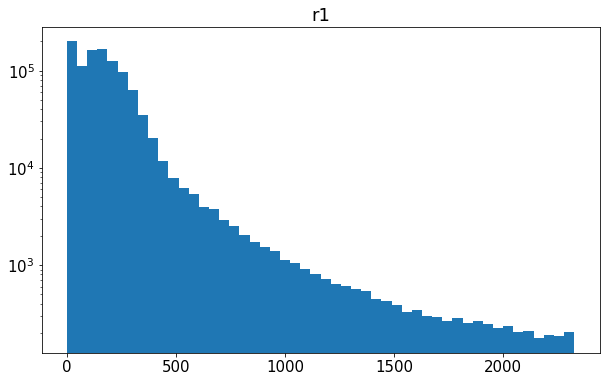

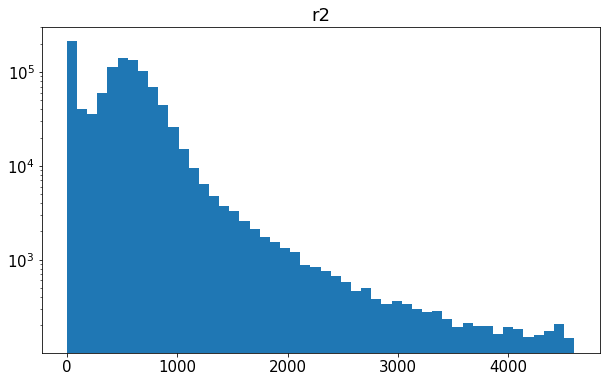

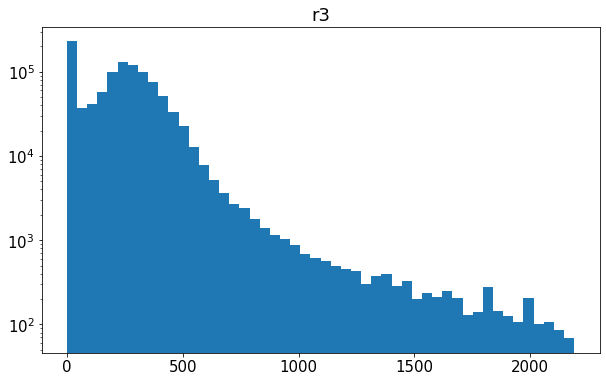

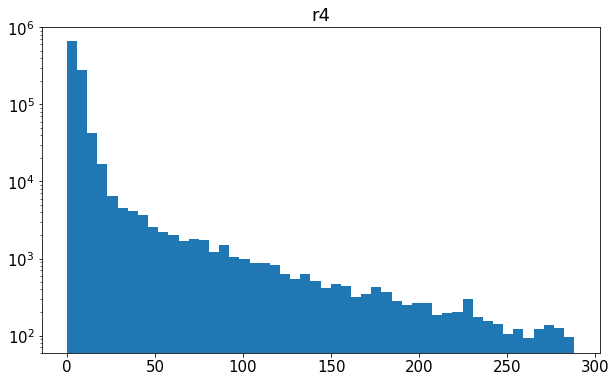

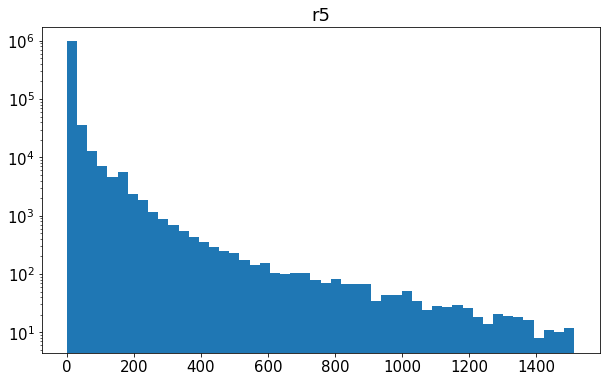

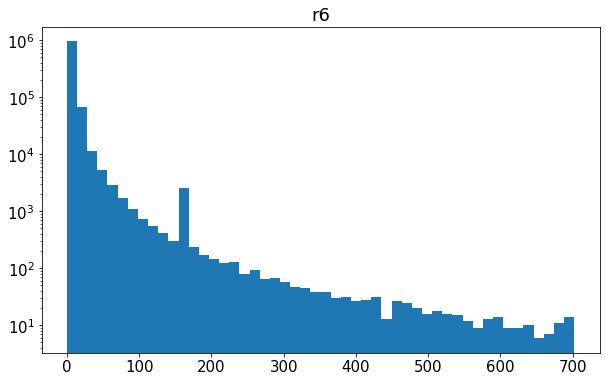

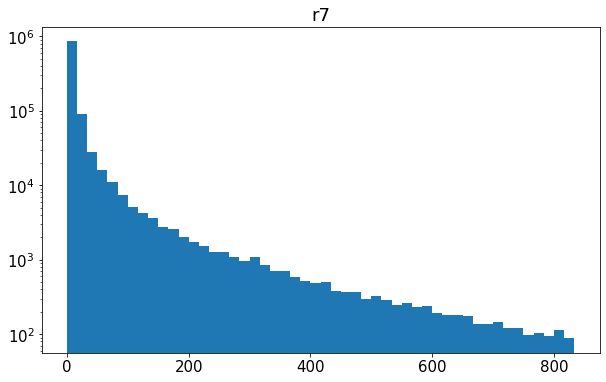

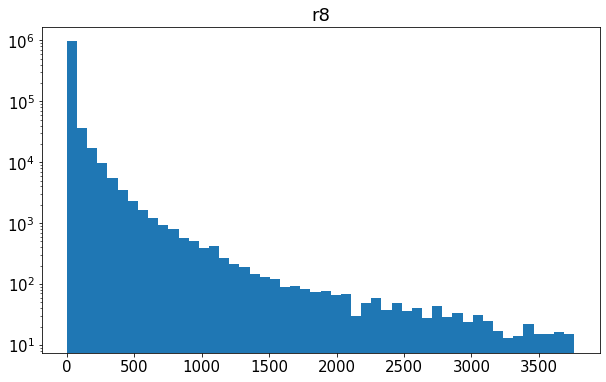

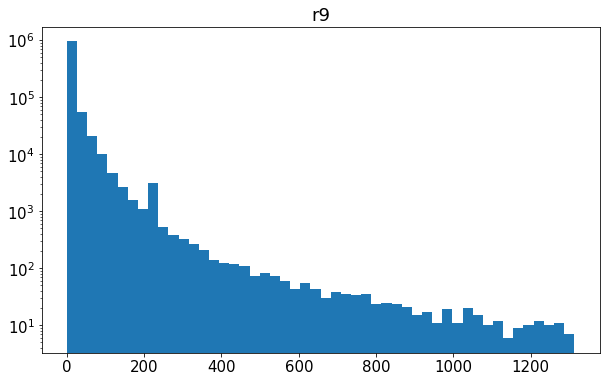

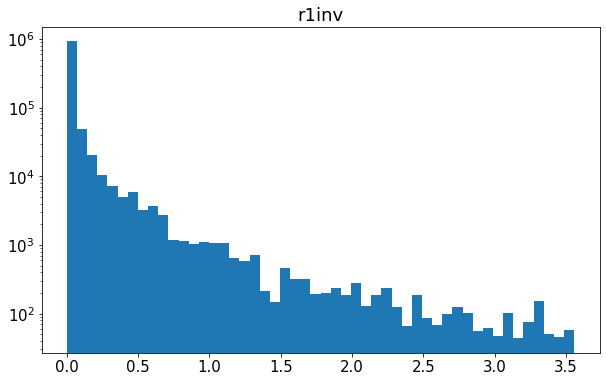

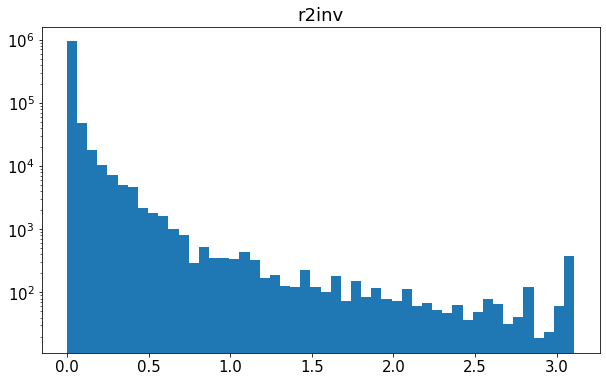

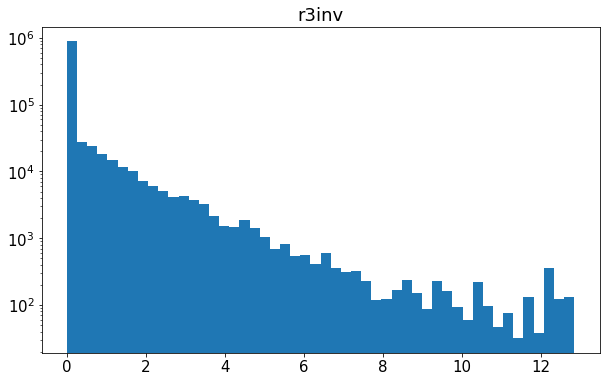

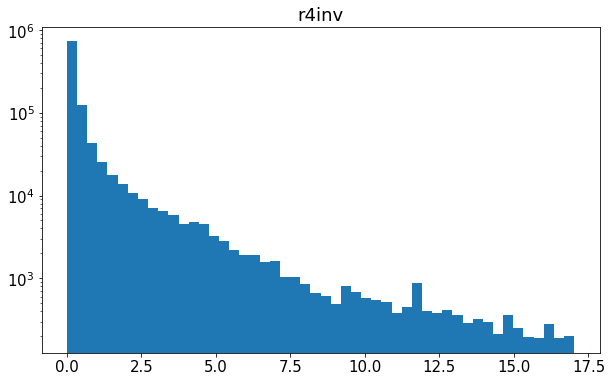

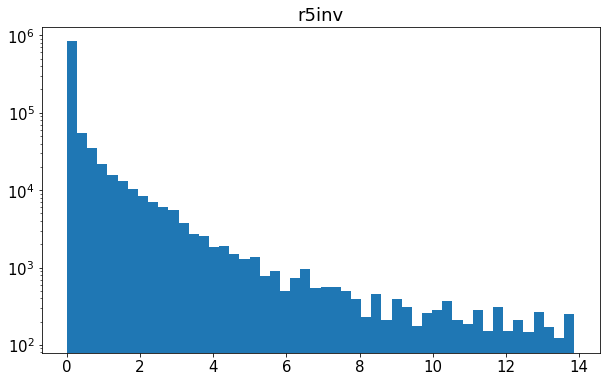

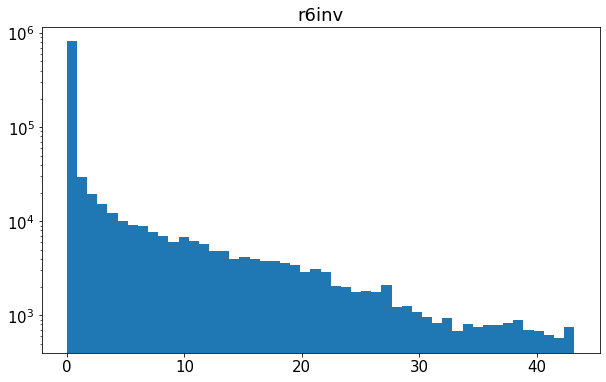

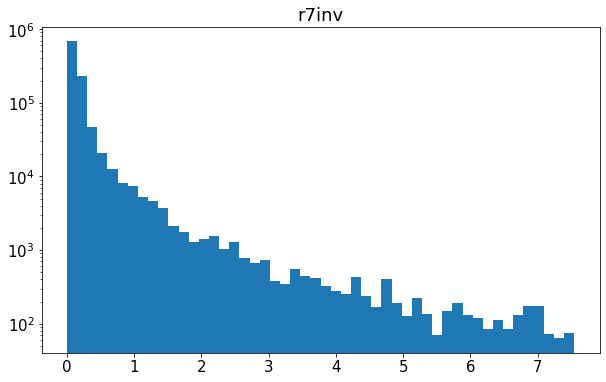

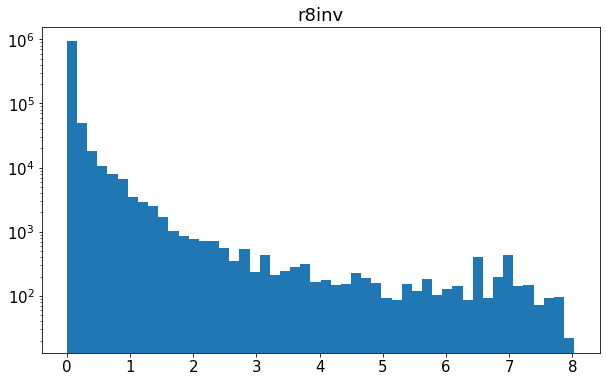

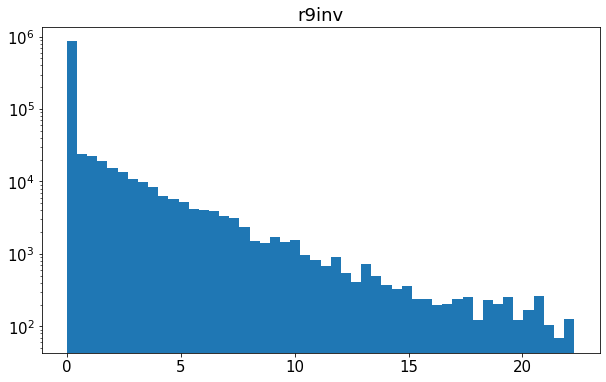

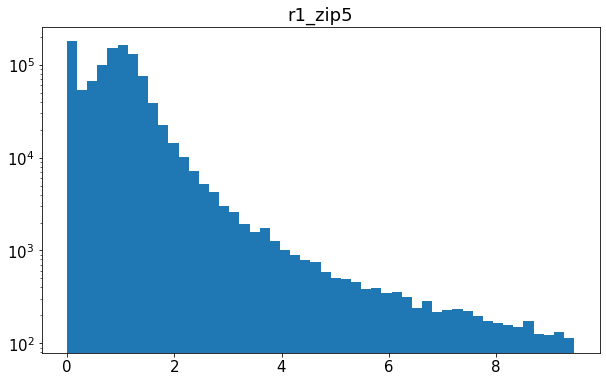

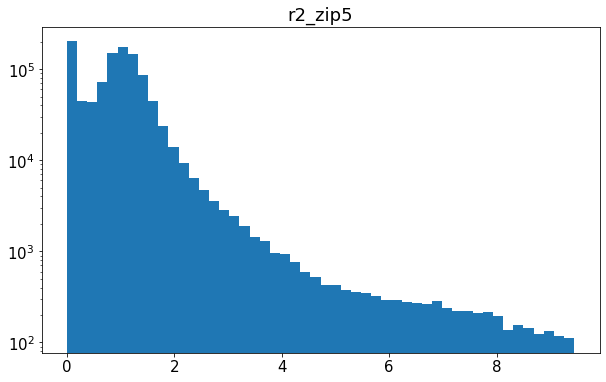

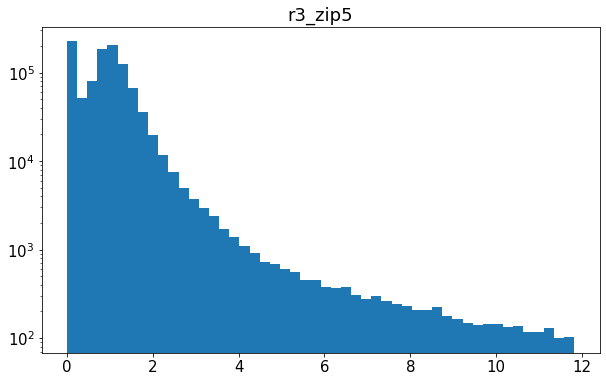

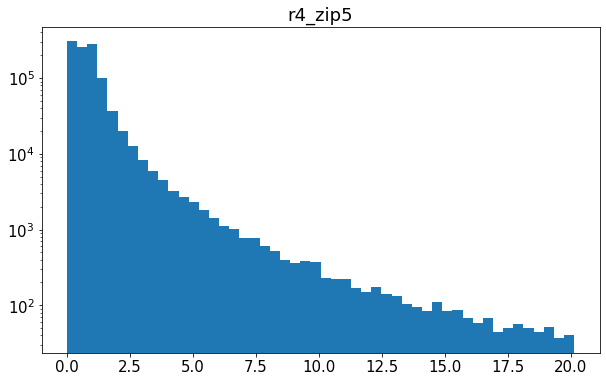

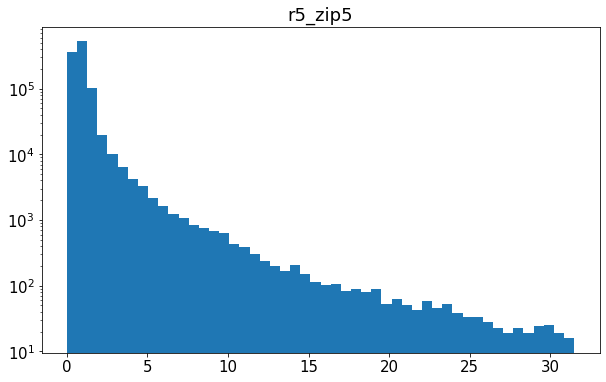

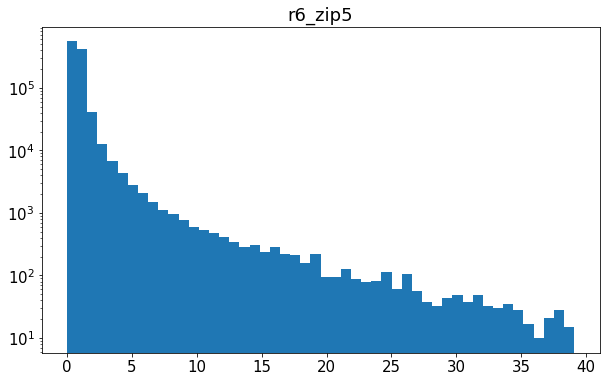

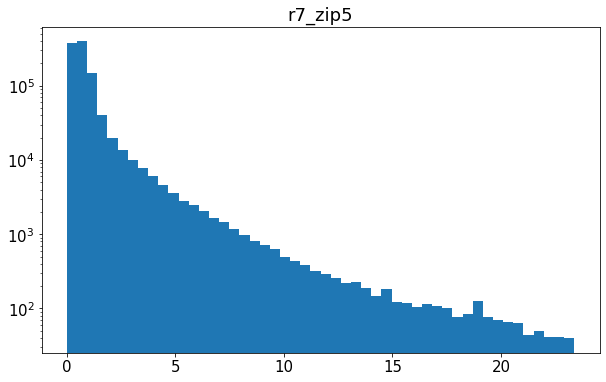

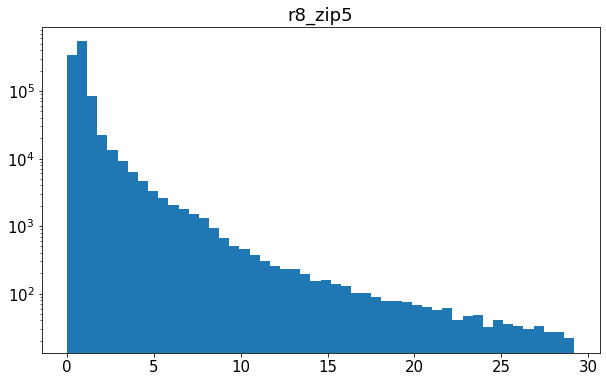

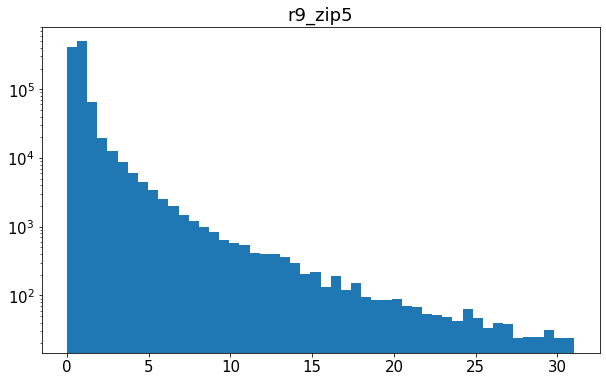

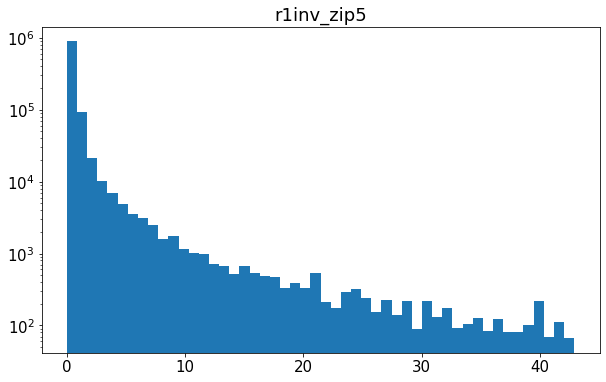

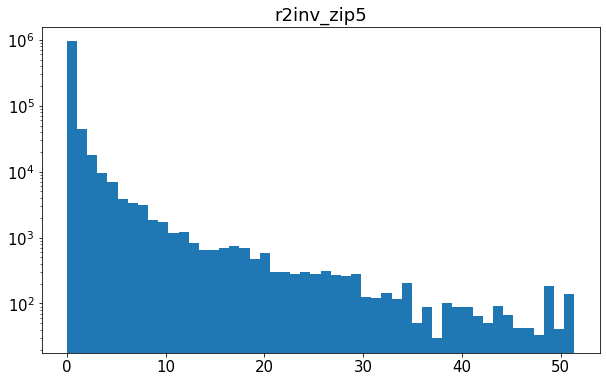

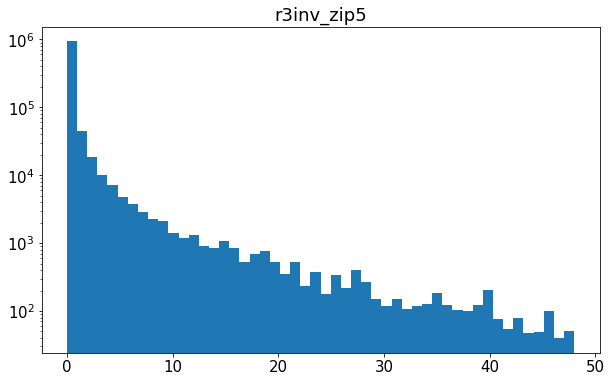

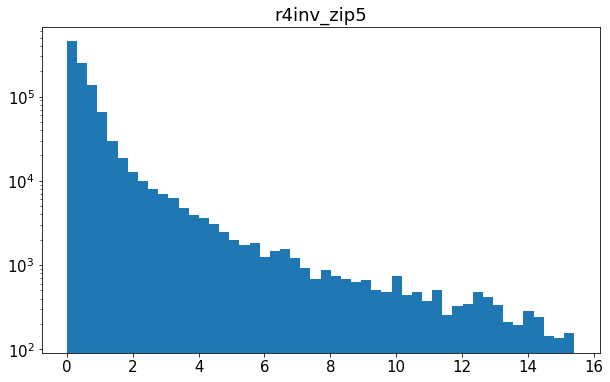

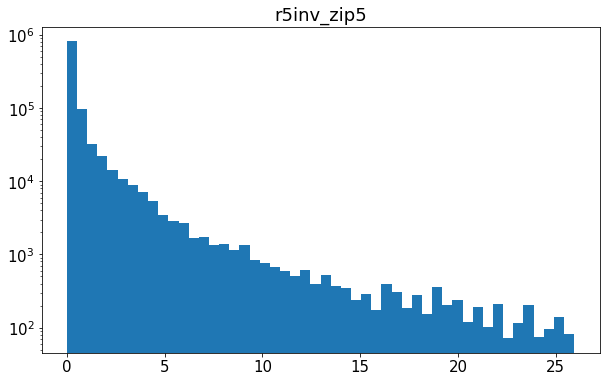

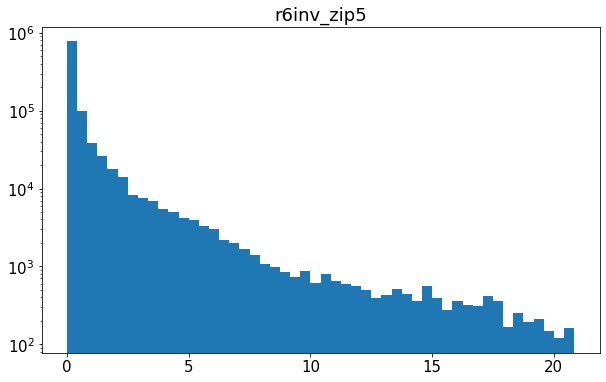

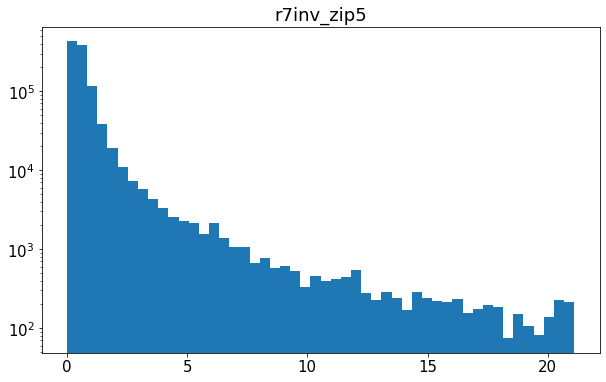

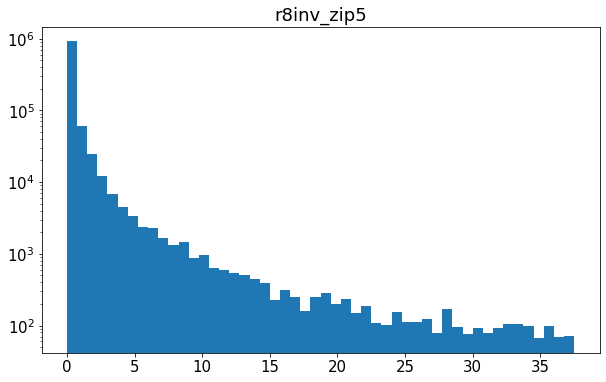

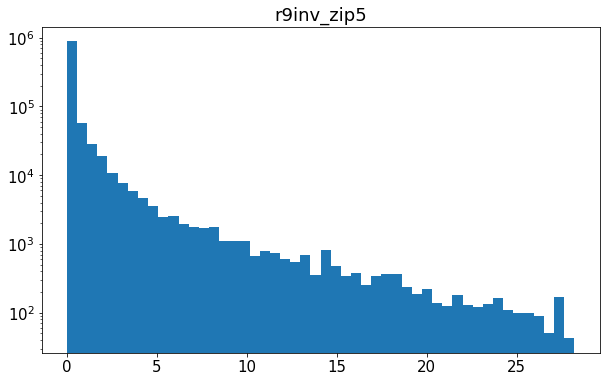

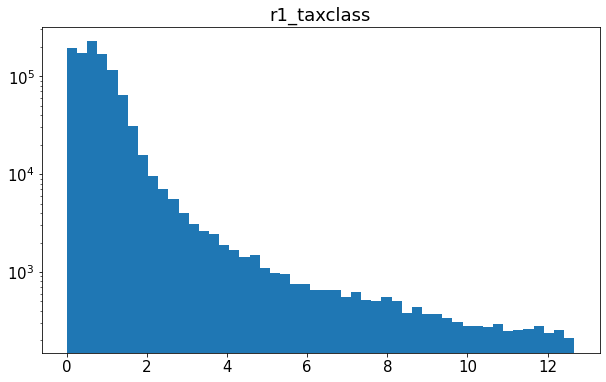

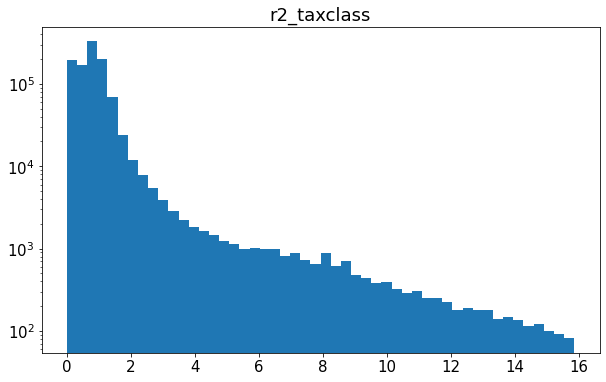

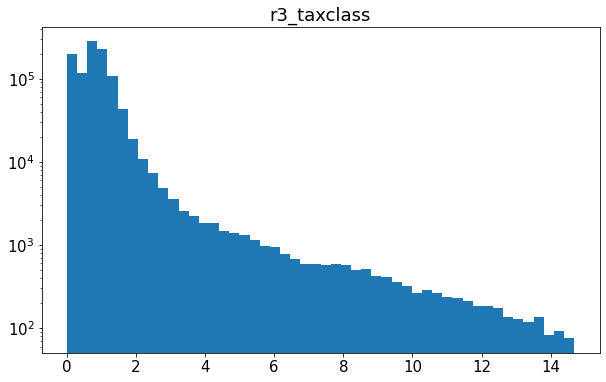

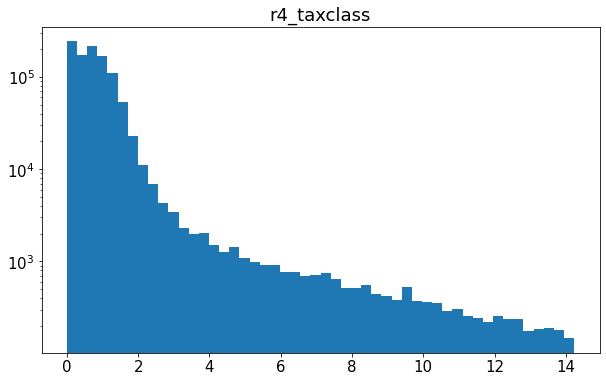

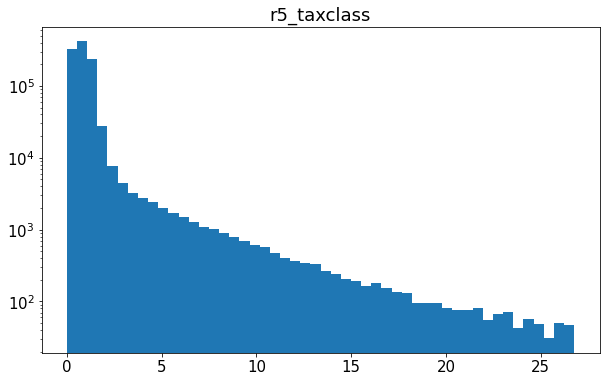

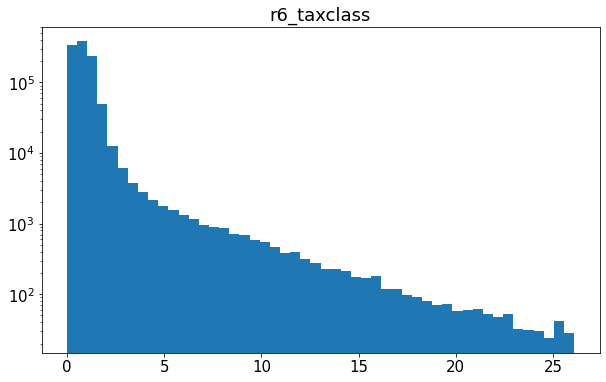

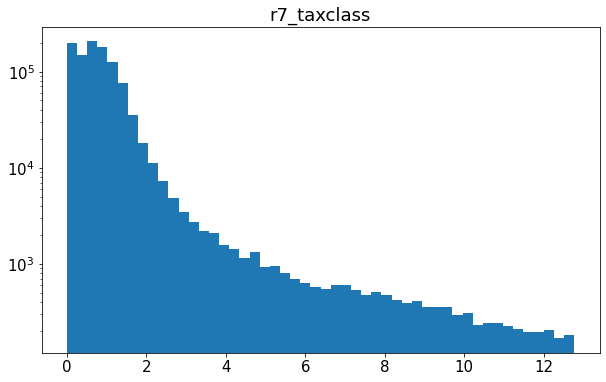

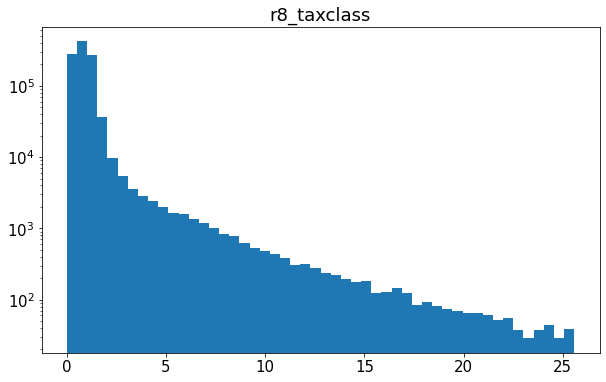

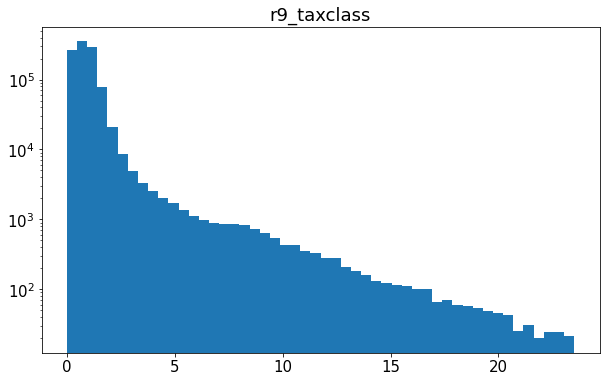

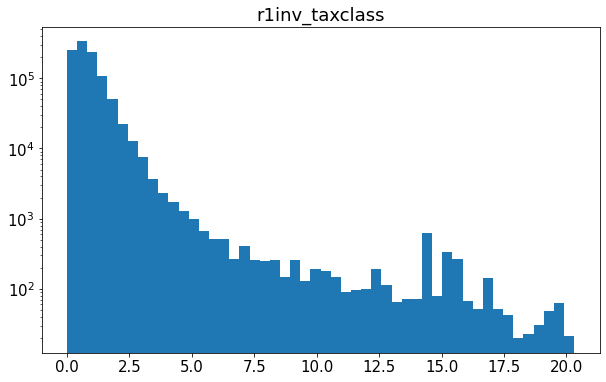

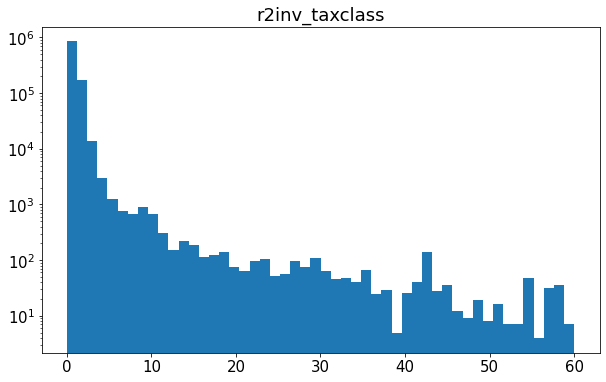

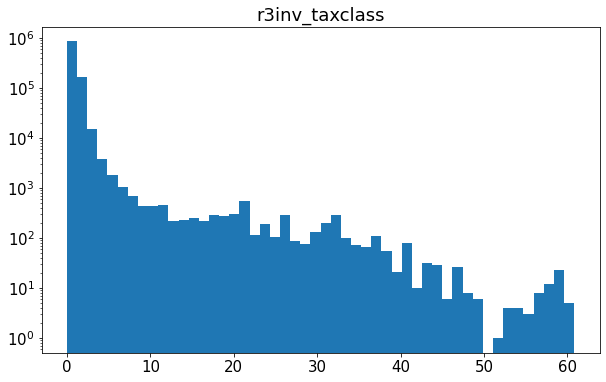

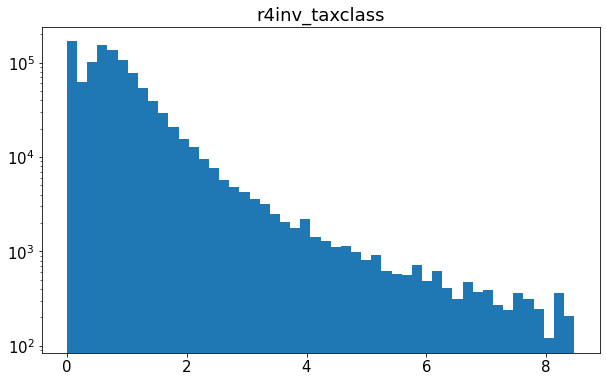

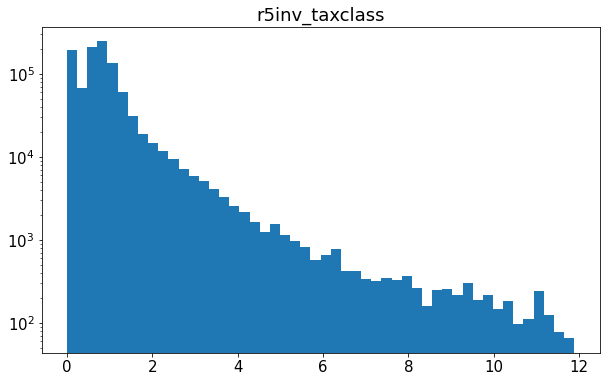

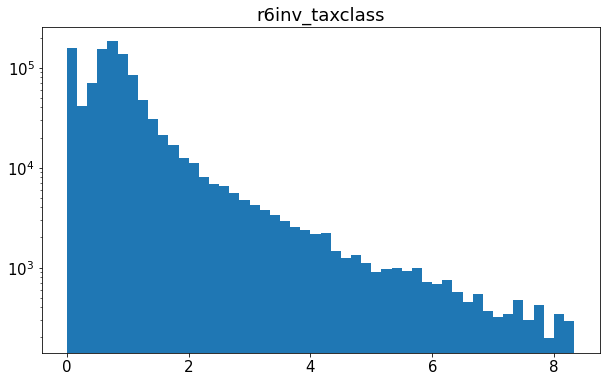

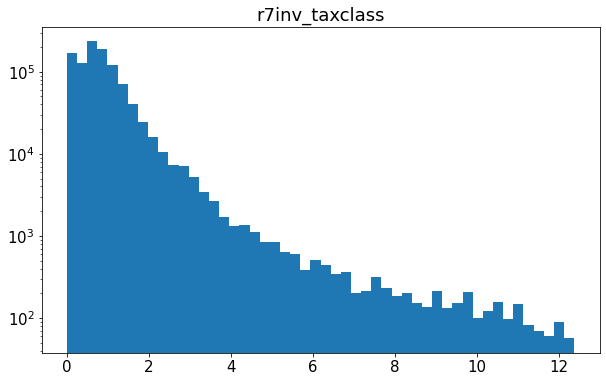

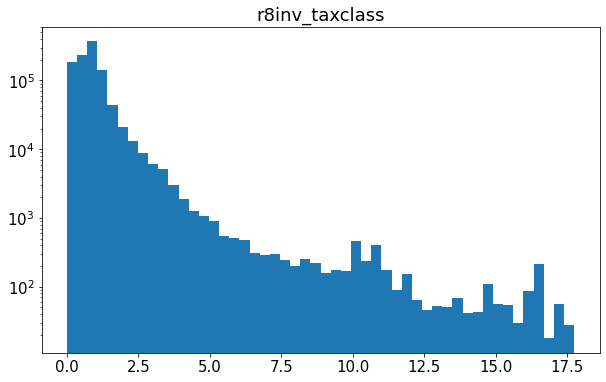

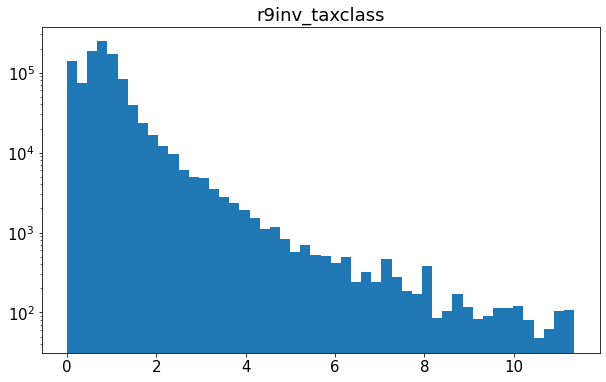

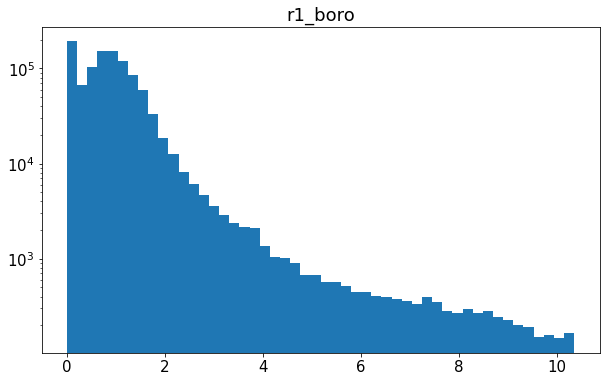

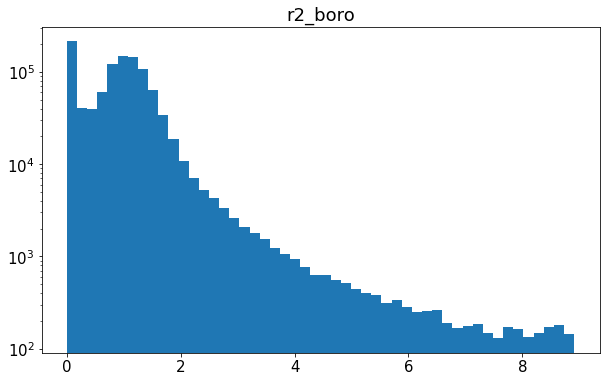

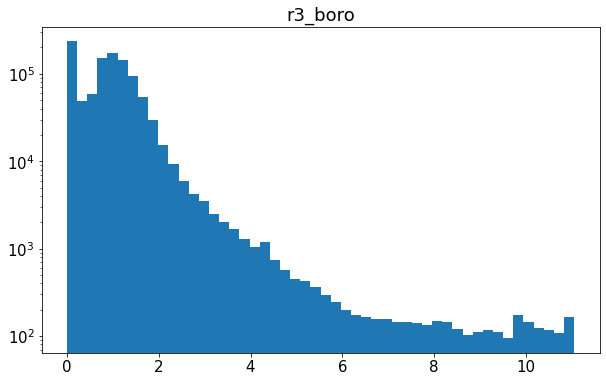

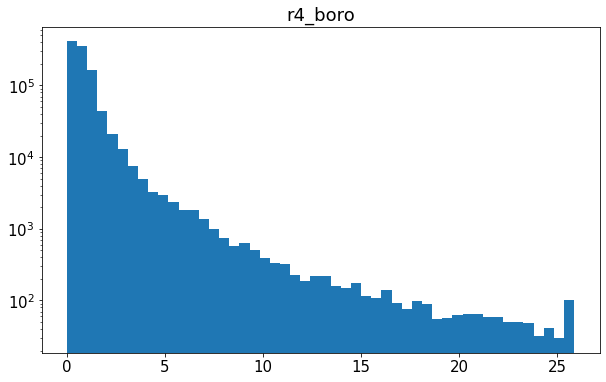

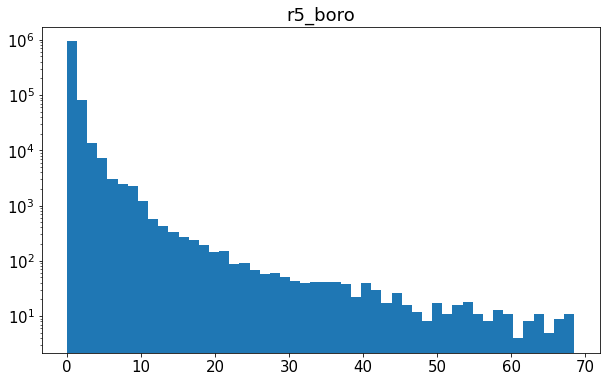

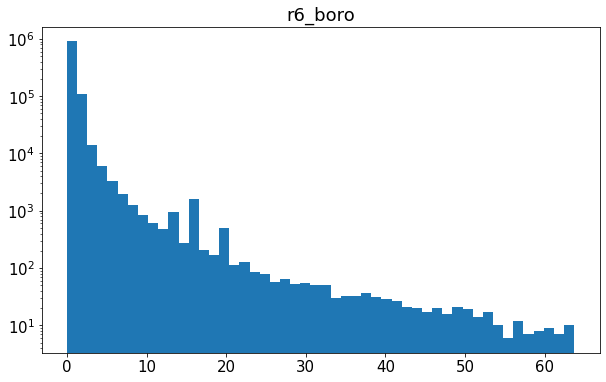

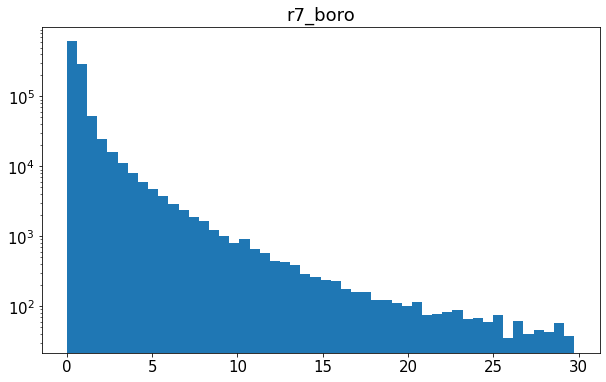

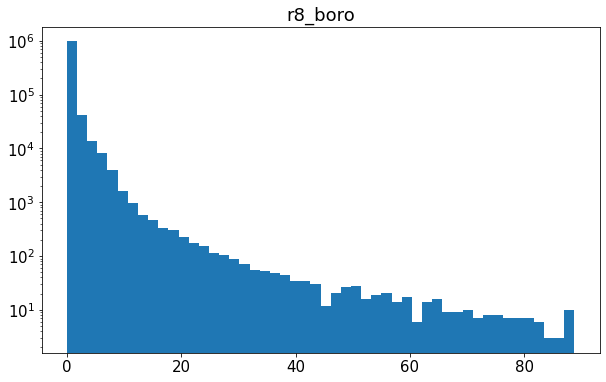

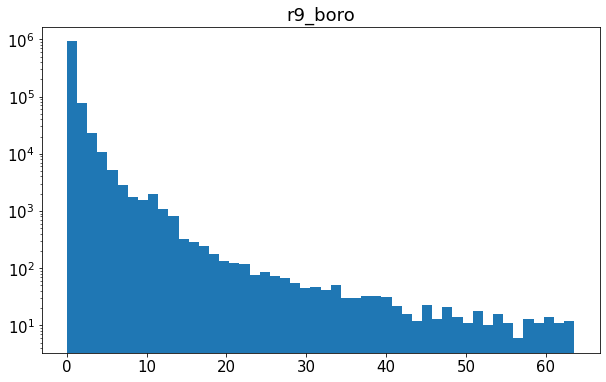

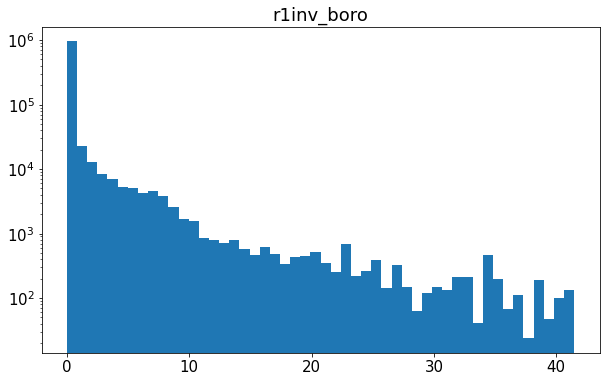

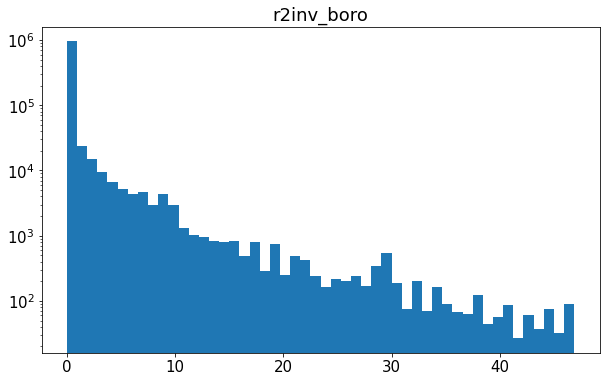

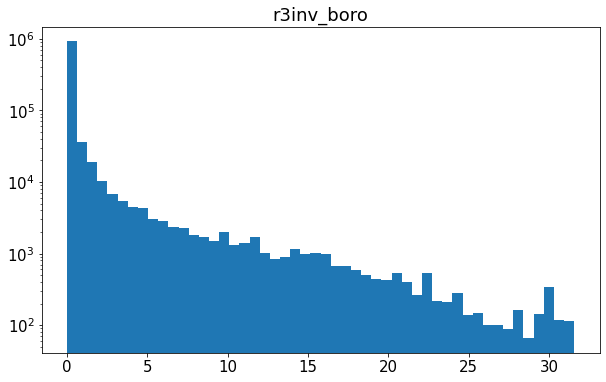

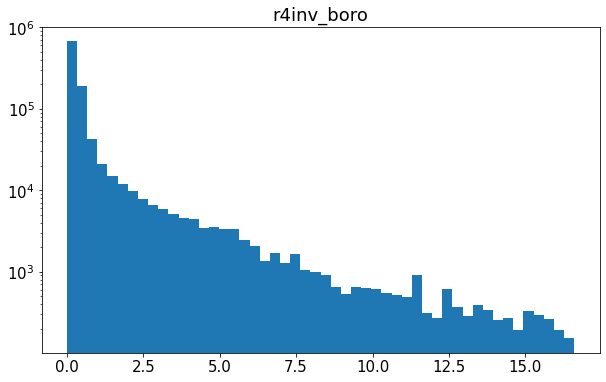

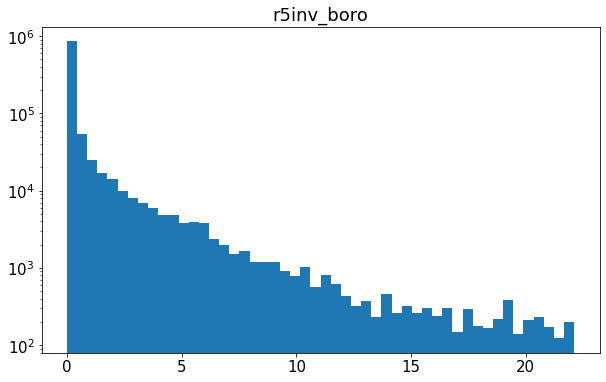

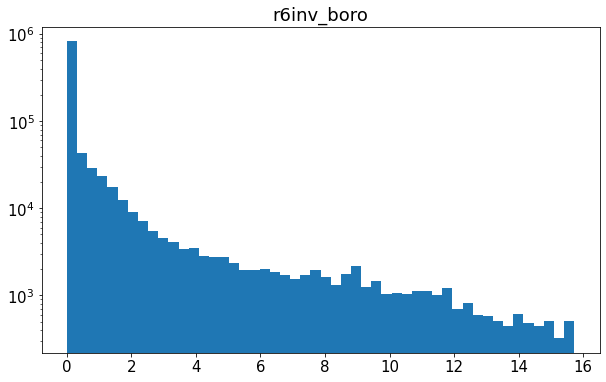

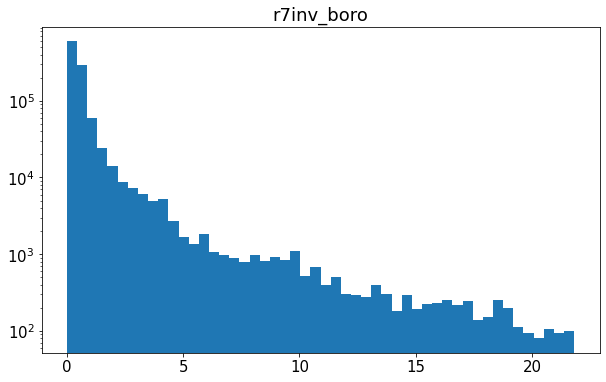

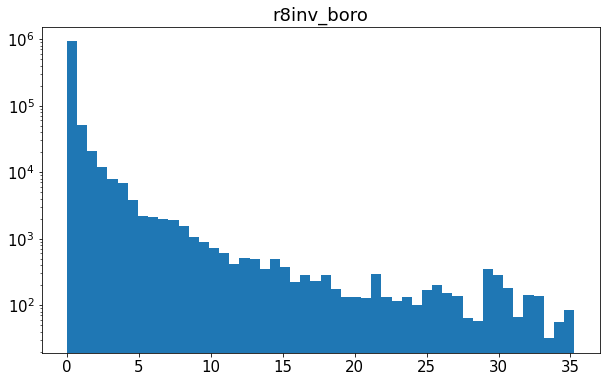

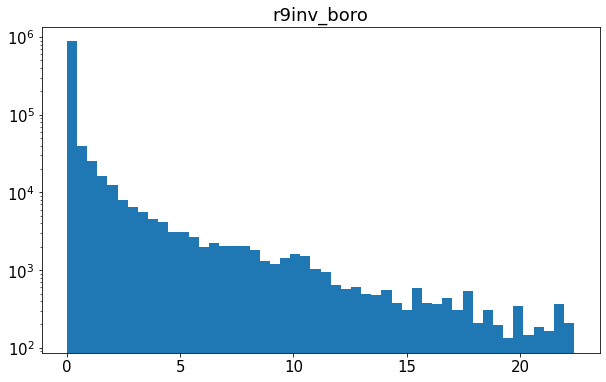

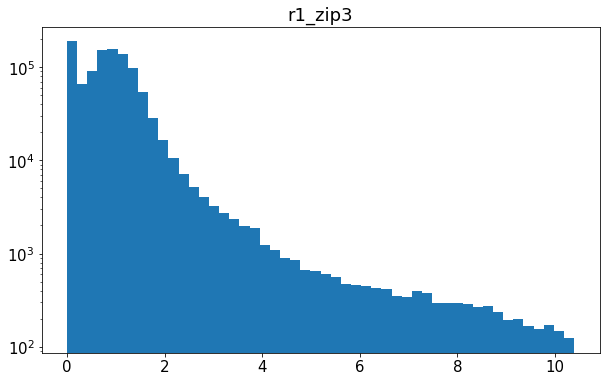

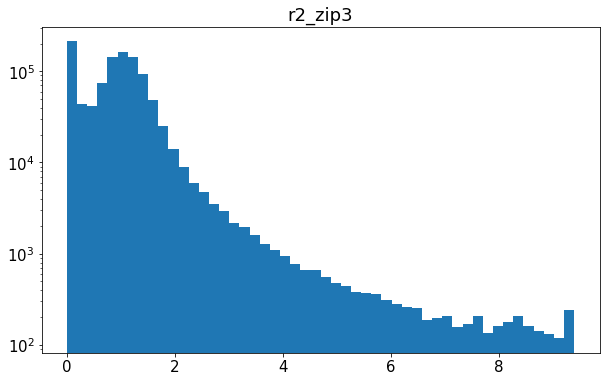

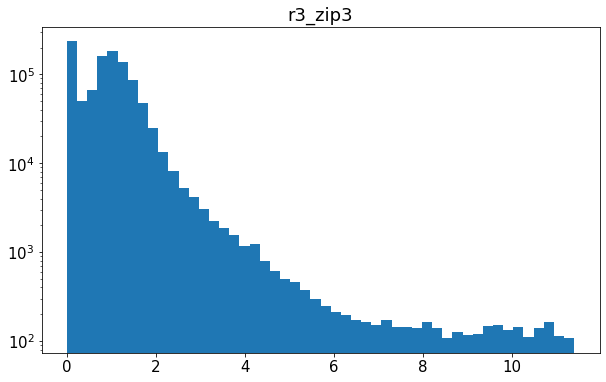

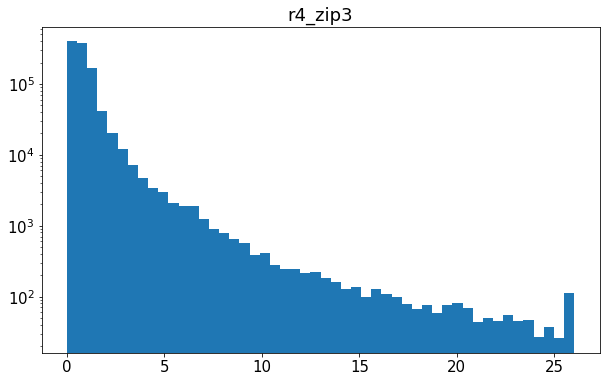

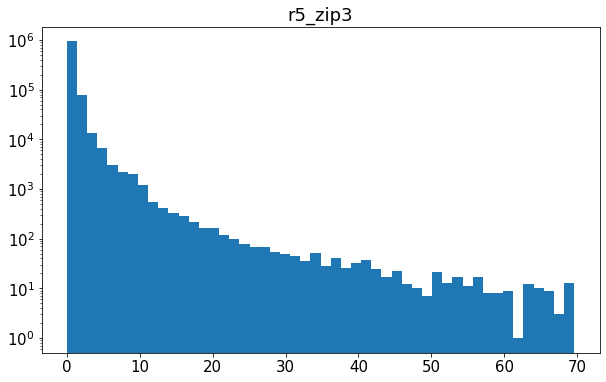

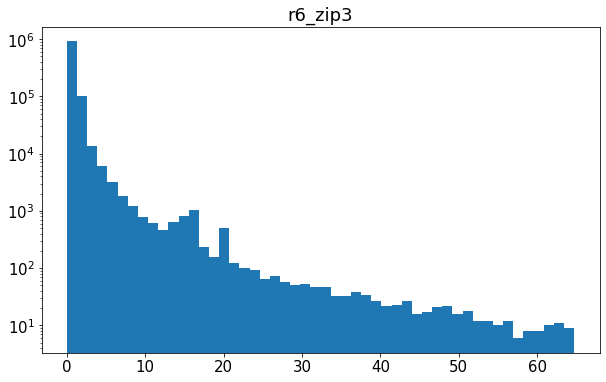

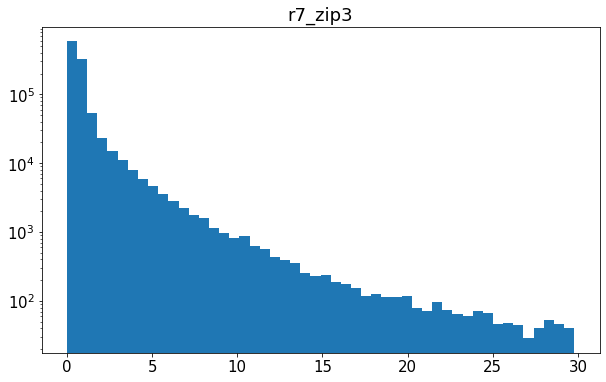

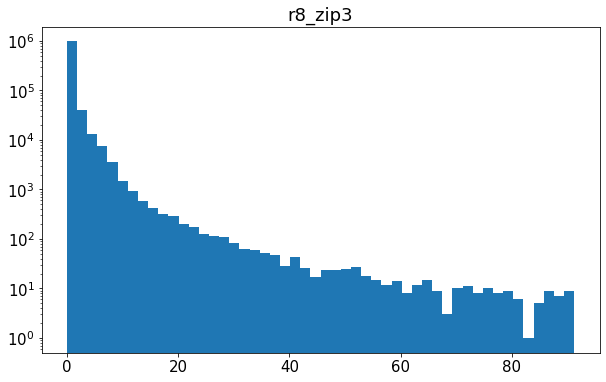

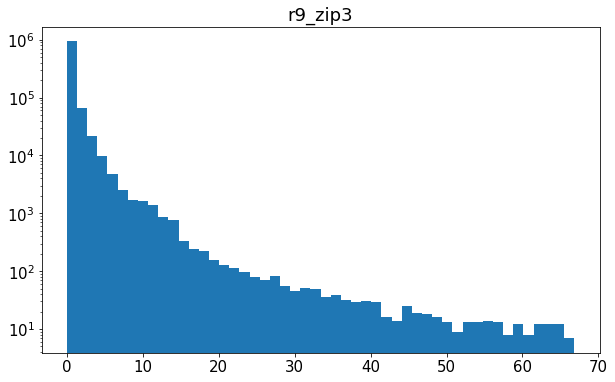

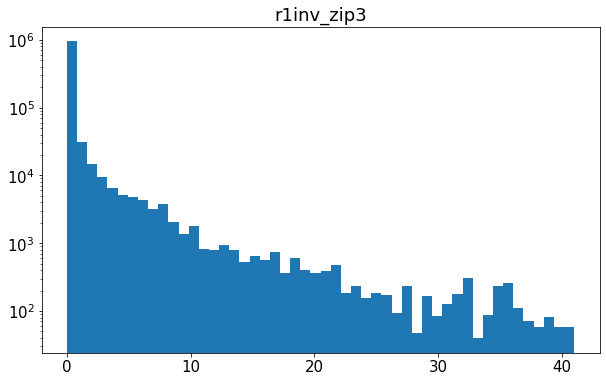

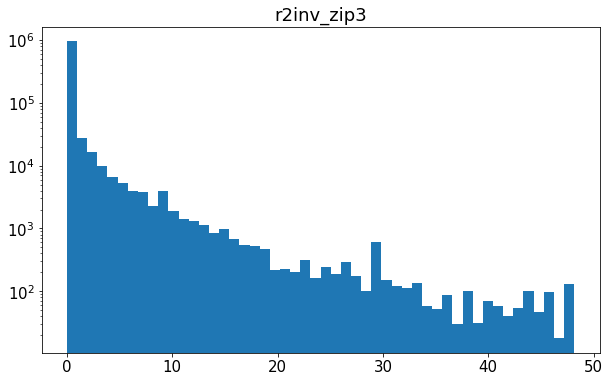

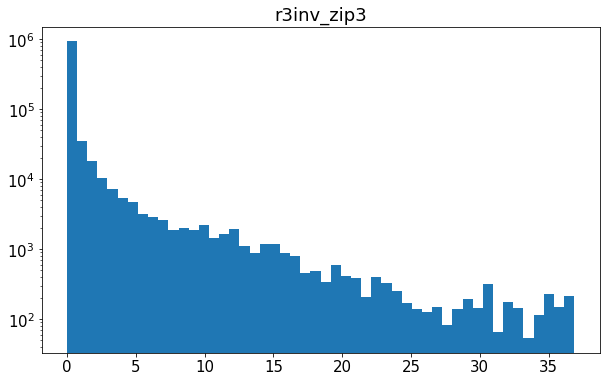

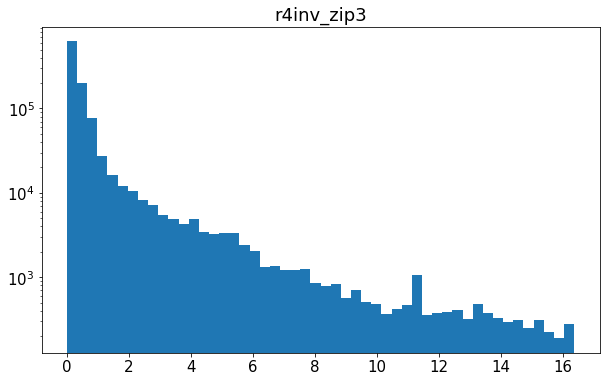

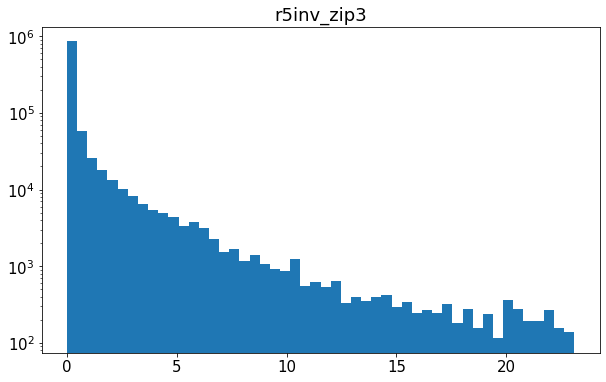

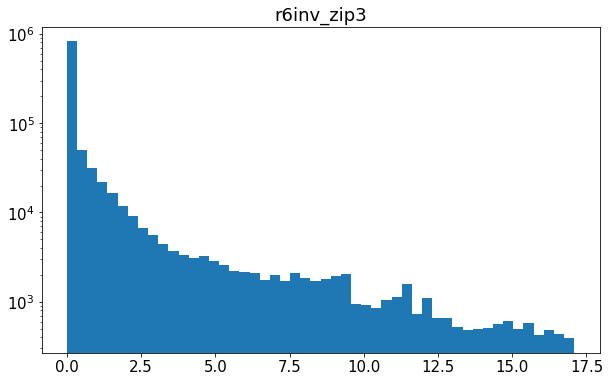

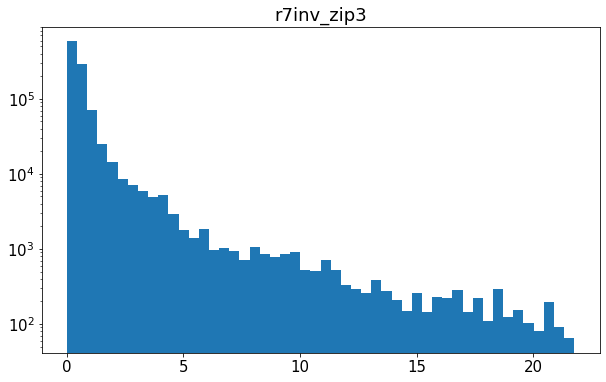

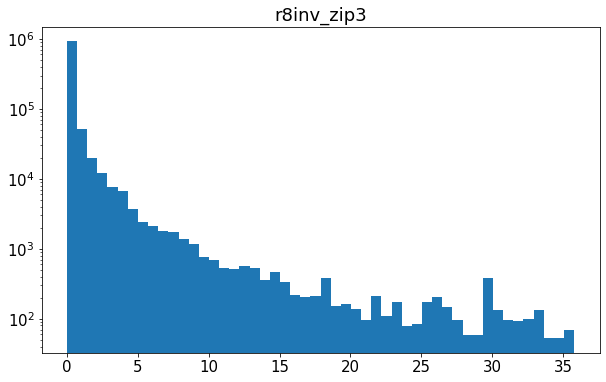

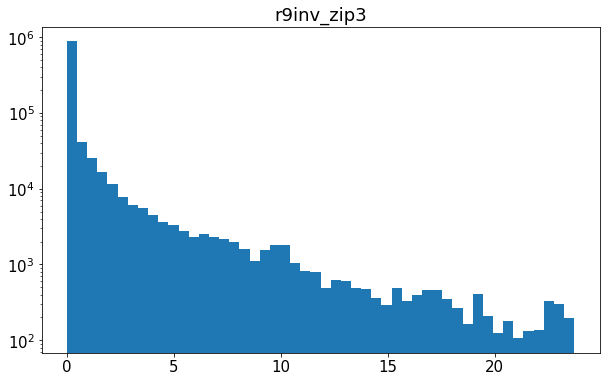

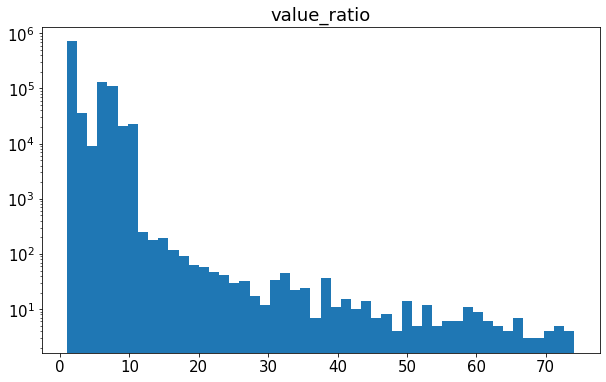

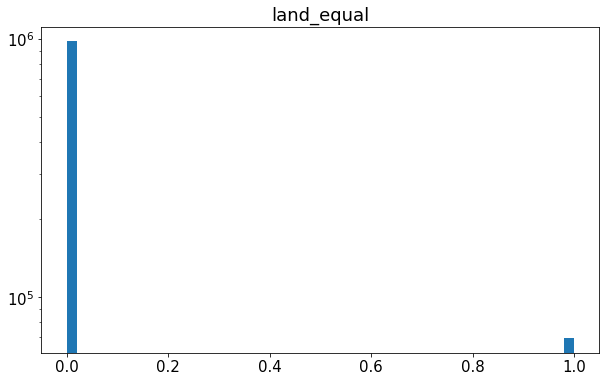

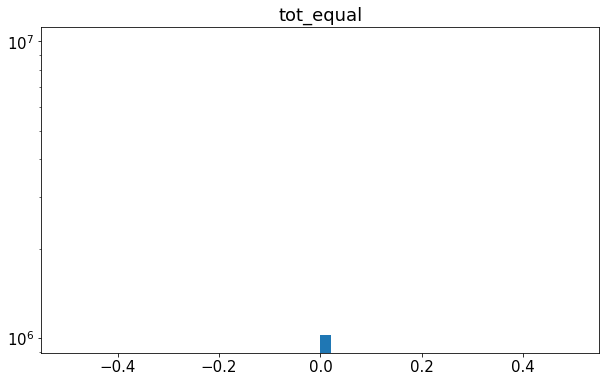

In [93]:
%%time
nstd = 4
for col in data.columns:
    plt.rcParams['figure.figsize'] = [10,6]
    plt.figure()
    plt.rcParams['font.size'] = 15
    plt.yscale('log')
    xstdev = data[col].std()
    xmean = data[col].mean()
    temp = data[data[col] <= xmean + nstd*xstdev]
    temp = temp[data[col] >= xmean - nstd*xstdev]
    plt.hist(temp[col],bins=50)
    plt.title(col)

In [50]:
# data.to_csv('NY vars.csv', index=False)

In [94]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r3inv_zip3,r4inv_zip3,r5inv_zip3,r6inv_zip3,r7inv_zip3,r8inv_zip3,r9inv_zip3,value_ratio,land_equal,tot_equal
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,...,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,-4.987863e-14,-4.120539e-14,-4.213792e-15,-1.192801e-14,-1.523930e-15,6.895732e-16,-4.875373e-14,-2.857037e-15,-1.090882e-14,-2.673658e-14,...,-7.955924e-15,4.086814e-14,1.188360e-14,-1.669900e-15,-2.473185e-15,-1.925049e-14,-9.660999e-15,3.903621e-14,2.885981e-14,-1.345536e-12
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.039724e-01,-5.279251e-01,-5.013145e-01,-1.505693e-01,-6.081250e-02,-5.747917e-02,-1.328478e-01,-5.410804e-02,-5.868685e-02,-9.412311e-02,...,-1.113150e-01,-2.604369e-01,-1.810400e-01,-2.486165e-01,-1.925922e-01,-1.148664e-01,-1.759532e-01,-1.184163e-01,-2.668428e-01,-1.587356e-01
25%,-2.594624e-01,-3.189799e-01,-3.312695e-01,-1.166346e-01,-4.417025e-02,-4.582967e-02,-1.066404e-01,-3.531737e-02,-3.673350e-02,-8.940407e-02,...,-1.101840e-01,-2.234776e-01,-1.648564e-01,-2.377693e-01,-1.448681e-01,-1.003469e-01,-1.639179e-01,-1.115971e-01,-2.668428e-01,-1.587356e-01
50%,-1.146377e-01,-3.567583e-02,-9.924473e-03,-8.434234e-02,-2.069159e-02,-1.627775e-02,-9.028477e-02,-2.510215e-02,-1.948221e-02,-8.661308e-02,...,-1.095149e-01,-1.950824e-01,-1.562505e-01,-2.277797e-01,-1.168866e-01,-9.253132e-02,-1.571789e-01,-1.025660e-01,-2.668428e-01,-1.587356e-01
75%,5.618853e-02,1.453654e-01,1.897425e-01,-4.649066e-02,-6.489343e-03,4.138601e-04,-6.574734e-02,-1.540155e-02,-4.344369e-03,-7.907924e-02,...,-1.009633e-01,-1.142729e-01,-1.231633e-01,-1.862842e-01,-6.588518e-02,-7.960021e-02,-1.376666e-01,1.639690e-01,-2.668428e-01,-1.587356e-01
max,2.563182e+02,3.053981e+02,4.670439e+02,3.171908e+02,8.965594e+02,6.432875e+02,3.142499e+02,9.373068e+02,8.985515e+02,1.105466e+02,...,1.772368e+02,5.069280e+01,7.577163e+01,5.796263e+01,7.643267e+01,6.318731e+01,4.432941e+01,5.616993e+02,3.747521e+00,6.299776e+00


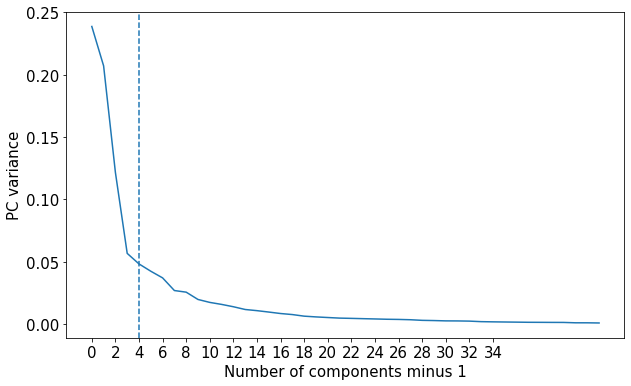

In [96]:
# do a PCA and look at the cumulative variance plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

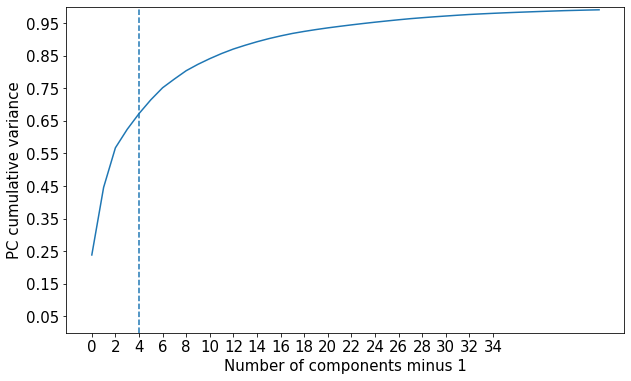

In [97]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [98]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

CPU times: user 42.1 s, sys: 6.15 s, total: 48.3 s
Wall time: 20.8 s


5

In [99]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.23865262 0.44569575 0.56721585 0.62382891 0.6719935 ]


In [100]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1046516, 5)

In [101]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,4.022066,7.005623,-1.780841,-5.760840,-1.095426
1,60.818181,105.262104,201.578352,-55.199141,-4.599748
2,1.242542,-0.239798,0.655142,0.400556,-0.289564
3,1.536349,0.297737,1.391590,0.124847,-0.312274
4,2.153868,1.411644,2.929338,-0.882850,-0.400177


In [102]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,1.835052e-16,1.836301e-16,-7.130657e-15,-1.480772e-15,-2.432390e-16
std,4.711125e+00,4.388053e+00,3.361751e+00,2.294562e+00,2.116437e+00
min,-3.802148e+02,-1.302700e+00,-7.868738e+02,-4.601358e+02,-1.295658e+02
25%,3.081593e-01,-5.032039e-01,-5.194746e-01,-3.274762e-01,-1.460296e-01
50%,7.031823e-01,-3.147224e-01,-2.356050e-01,-1.663008e-02,2.214229e-02
75%,9.197152e-01,-1.019001e-01,7.153229e-02,6.969763e-01,1.638717e-01
max,1.020699e+03,2.997117e+03,1.089170e+03,1.303422e+03,4.447892e+02


In [103]:
# zscale the pcs. This is an optional step, and I like to make all the retained PCs equally important.
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,5.703909e-16,-1.665341e-16,1.177779e-15,6.638577e-16,-4.021409e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.070574e+01,-2.968742e-01,-2.340667e+02,-2.005332e+02,-6.121884e+01
25%,6.541098e-02,-1.146759e-01,-1.545250e-01,-1.427184e-01,-6.899782e-02
50%,1.492600e-01,-7.172256e-02,-7.008402e-02,-7.247606e-03,1.046206e-02
75%,1.952220e-01,-2.322217e-02,2.127828e-02,3.037513e-01,7.742809e-02
max,2.166571e+02,6.830175e+02,3.239890e+02,5.680482e+02,2.101594e+02


In [104]:
data_pca_zs.shape

(1046516, 5)

In [105]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.853738,1.596522,-0.529736,-2.510649,-0.517580
1,12.909483,23.988338,59.962310,-24.056504,-2.173345
2,0.263746,-0.054648,0.194881,0.174568,-0.136817
3,0.326111,0.067852,0.413948,0.054410,-0.147547
4,0.457188,0.321702,0.871373,-0.384757,-0.189081


## Now calculate two unsupervised fraud scores

In [106]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
p1 = 2
p2 = 2
ntop = 1000

### Calculate score 1

In [107]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0     3.182706
1    70.149930
2     0.399650
3     0.554108
4     1.120532
5     0.516863
6     0.408375
7     0.415925
8     0.824242
9     0.794801
dtype: float64

In [108]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,0.853738,1.596522,-0.529736,-2.510649,-0.517580
1,12.909483,23.988338,59.962310,-24.056504,-2.173345
2,0.263746,-0.054648,0.194881,0.174568,-0.136817
3,0.326111,0.067852,0.413948,0.054410,-0.147547
4,0.457188,0.321702,0.871373,-0.384757,-0.189081
5,0.140035,-0.251686,-0.169483,0.376648,-0.116631
6,0.202547,-0.166797,-0.007781,0.286121,-0.126482
7,0.197429,-0.175380,-0.023513,0.294822,-0.125637
8,0.396750,0.209989,0.667249,-0.084360,-0.159783
9,0.389621,0.195555,0.641549,-0.070284,-0.158546


In [109]:
score1.max()

945.854824574509

### Autoencoder for score 2

In [110]:
%%time
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

CPU times: user 57.7 s, sys: 349 ms, total: 58 s
Wall time: 58.5 s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [135]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [136]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,3.182706,2.528247,1
1,70.149930,33.243771,2
2,0.399650,0.242762,9
3,0.554108,0.282983,10
4,1.120532,0.288568,11
5,0.516863,0.201612,12
6,0.408375,0.214429,13
7,0.415925,0.212738,14
8,0.824242,0.335996,15
9,0.794801,0.330427,16


In [137]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,3.182706,2.528247,1,1024588.0,1040560.0
1,70.149930,33.243771,2,1046441.0,1046338.0
2,0.399650,0.242762,9,619147.0,756828.0
3,0.554108,0.282983,10,756289.0,831964.0
4,1.120532,0.288568,11,972308.0,839981.0
5,0.516863,0.201612,12,713980.0,621323.0
6,0.408375,0.214429,13,626673.0,677347.0
7,0.415925,0.212738,14,632807.0,670912.0
8,0.824242,0.335996,15,933686.0,895892.0
9,0.794801,0.330427,16,927312.0,890551.0


In [138]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
0,3.182706,2.528247,1,1024588.0,1040560.0,1032574.0
1,70.149930,33.243771,2,1046441.0,1046338.0,1046389.5
2,0.399650,0.242762,9,619147.0,756828.0,687987.5
3,0.554108,0.282983,10,756289.0,831964.0,794126.5
4,1.120532,0.288568,11,972308.0,839981.0,906144.5
5,0.516863,0.201612,12,713980.0,621323.0,667651.5
6,0.408375,0.214429,13,626673.0,677347.0,652010.0
7,0.415925,0.212738,14,632807.0,670912.0,651859.5
8,0.824242,0.335996,15,933686.0,895892.0,914789.0
9,0.794801,0.330427,16,927312.0,890551.0,908931.5


In [139]:
scores_sorted.head(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
898718,945.854825,945.679585,917942,1046516.0,1046516.0,1046516.0
1036106,349.800897,327.842860,1059883,1046515.0,1046515.0,1046515.0
11984,257.681635,235.312831,12076,1046514.0,1046514.0,1046514.0
241764,251.631451,230.730499,252834,1046513.0,1046513.0,1046513.0
648311,246.469730,229.469693,665158,1046512.0,1046512.0,1046512.0
935946,224.024173,192.126441,956520,1046511.0,1046511.0,1046511.0
914459,213.566893,190.093503,934793,1046509.0,1046510.0,1046509.5
148112,217.637395,189.782750,151044,1046510.0,1046509.0,1046509.5
317851,201.027408,177.703756,330291,1046508.0,1046508.0,1046508.0
137438,196.888159,170.944184,139726,1046507.0,1046507.0,1046507.0


In [140]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
893760,0.156376,0.010836,912862,619.5,49.5,334.5
893758,0.156376,0.010836,912860,619.5,49.5,334.5
893740,0.156376,0.010836,912842,619.5,49.5,334.5
893742,0.156376,0.010836,912844,619.5,49.5,334.5
893761,0.152276,0.010671,912863,450.0,44.0,247.0
860032,0.153080,0.008197,878576,477.5,12.5,245.0
860031,0.153080,0.008197,878575,477.5,12.5,245.0
296775,0.143093,0.012292,308661,278.0,154.0,216.0
317274,0.136682,0.009280,329712,188.0,19.0,103.5
389313,0.101429,0.012513,404036,20.0,161.0,90.5


In [141]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,6.228891e-01,2.560483e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,2.147559e+00,1.508403e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.884674e+05
min,5.817369e-02,6.325465e-03,1.000000e+00,1.000000e+00,1.500000e+00,9.050000e+01
25%,2.347576e-01,9.472963e-02,2.731068e+05,2.616298e+05,2.616265e+05,2.692525e+05
50%,3.229137e-01,1.776593e-01,5.389795e+05,5.232585e+05,5.232582e+05,5.293790e+05
75%,5.693199e-01,2.561290e-01,8.026112e+05,7.848872e+05,7.848872e+05,7.619692e+05
max,9.458548e+02,9.456796e+02,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [142]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06,1.046516e+06
mean,6.228891e-01,2.560483e-01,5.370414e+05,5.232585e+05,5.232585e+05,5.232585e+05
std,2.147559e+00,1.508403e+00,3.080583e+05,3.021033e+05,3.021033e+05,2.884674e+05
min,5.817369e-02,6.325465e-03,1.000000e+00,1.000000e+00,1.500000e+00,9.050000e+01
25%,2.347576e-01,9.472963e-02,2.731068e+05,2.616298e+05,2.616265e+05,2.692525e+05
50%,3.229137e-01,1.776593e-01,5.389795e+05,5.232585e+05,5.232582e+05,5.293790e+05
75%,5.693199e-01,2.561290e-01,8.026112e+05,7.848872e+05,7.848872e+05,7.619692e+05
max,9.458548e+02,9.456796e+02,1.070994e+06,1.046516e+06,1.046516e+06,1.046516e+06


In [143]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,945.854825,945.679585,1046516.0,1046516.0,1046516.0
1059883,349.800897,327.842860,1046515.0,1046515.0,1046515.0
12076,257.681635,235.312831,1046514.0,1046514.0,1046514.0
252834,251.631451,230.730499,1046513.0,1046513.0,1046513.0
665158,246.469730,229.469693,1046512.0,1046512.0,1046512.0
956520,224.024173,192.126441,1046511.0,1046511.0,1046511.0
934793,213.566893,190.093503,1046509.0,1046510.0,1046509.5
151044,217.637395,189.782750,1046510.0,1046509.0,1046509.5
330291,201.027408,177.703756,1046508.0,1046508.0,1046508.0


(0.1, 2083260.5959372038)

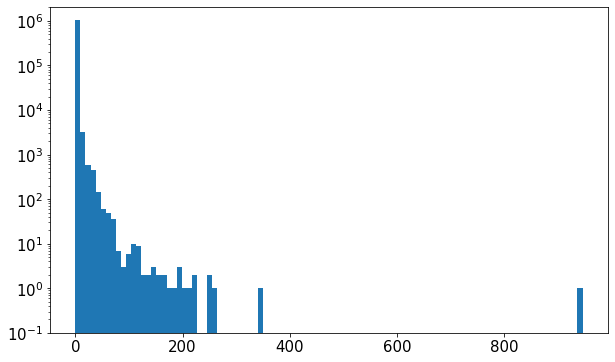

In [144]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [145]:
sc2max = int(score2.max())
sc2max

945

945


(0.1, 2091186.3044592806)

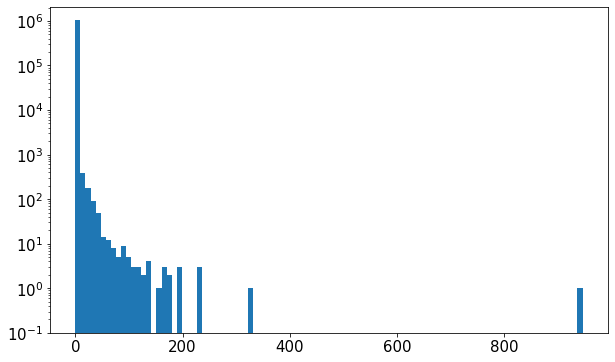

In [124]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(array([ 2405.,  4577.,  6282.,  8660., 10136., 10436.,  9876., 10156.,
         9901., 10574., 10448., 10611., 10751., 11094., 11146., 11411.,
        10912., 11531., 11676., 11713., 11982., 11660., 11834., 11820.,
        11680., 11701., 11788., 11892., 11942., 11556., 11302., 11378.,
        11412., 11499., 11179., 11261., 10991., 11105., 10491., 10732.,
        10736., 10194.,  9984.,  9713.,  9546.,  9591.,  9169.,  9107.,
         8669.,  8256.,  8112.,  7894.,  8310.,  8126.,  7795.,  7660.,
         7727.,  7838.,  7982.,  8426.,  9030.,  9968., 11146., 12347.,
        14284., 14774., 17427., 18054., 17450., 16464., 16012., 16581.,
        16004., 15129., 14602., 13874., 14142., 13388., 11885., 10840.,
        10215.,  9498.,  8232.,  7686.,  7087.,  8149.,  8663.,  8318.,
         7866.,  8521.,  8545.,  8536.,  8136.,  7851.,  8203.,  8036.,
         7942.,  7831.,  7724.,  7740.]),
 array([9.05000000e+01, 1.05547550e+04, 2.10190100e+04, 3.14832650e+04,
        4.19475200e+04

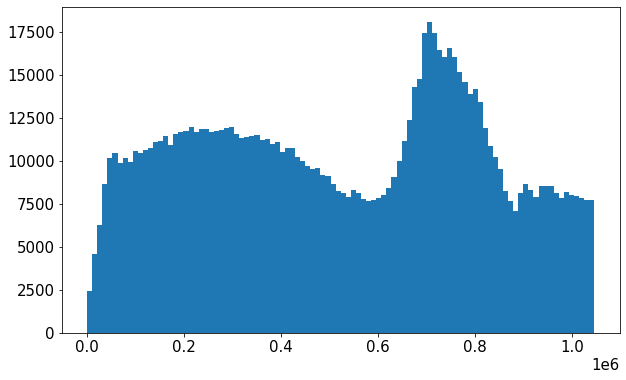

In [146]:
plt.hist(scores['final'],bins=100)

In [147]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 917942, 1059883,   12076,  252834,  665158,  956520,  934793,
             151044,  330291,  139726,
            ...
              49921,  248669,  938669,  938667,  982492, 1069992,  706710,
             310336,  876163,  529140],
           dtype='int64', name='RECORD', length=1000)


In [148]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r3inv_zip3,r4inv_zip3,r5inv_zip3,r6inv_zip3,r7inv_zip3,r8inv_zip3,r9inv_zip3,value_ratio,land_equal,tot_equal
RECORD,,,,,,,,,,,,,,,,,,,,,
9.0,-0.326552,3.406992,0.987422,-0.034199,2.052445,0.766972,-0.041524,1.879522,0.949207,-0.066039,...,-0.111225,-0.240340,-0.180848,-0.248448,-0.163568,-0.114595,-0.175783,0.267780,3.747521,6.299776
16.0,108.917366,35.106980,12.980793,61.297815,7.095909,2.734592,128.820205,17.456997,9.068879,-0.094112,...,-0.111306,-0.260406,-0.180985,-0.248567,-0.192579,-0.114837,-0.175935,0.188881,3.747521,6.299776
23.0,0.327495,0.197416,-0.471032,0.747304,0.257310,-0.043784,0.729977,0.302327,-0.038185,-0.091157,...,-0.106879,-0.257836,-0.179751,-0.238514,-0.189525,-0.113389,-0.167535,0.244919,-0.266843,-0.158736
24.0,0.653138,0.520331,-0.457550,1.147030,0.398936,-0.037686,1.114097,0.461008,-0.029058,-0.092074,...,-0.108245,-0.258639,-0.180149,-0.241617,-0.190472,-0.113844,-0.170126,0.244919,-0.266843,-0.158736
25.0,1.561562,1.421145,-0.419941,1.215100,0.423053,-0.036648,2.185654,0.903671,-0.003596,-0.093025,...,-0.109664,-0.258729,-0.180193,-0.241965,-0.191455,-0.114317,-0.172818,0.200154,-0.266843,-0.158736


In [150]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
1,1024588.0,1040560.0,1032574.0
2,1046441.0,1046338.0,1046389.5
9,619147.0,756828.0,687987.5
10,756289.0,831964.0,794126.5
11,972308.0,839981.0,906144.5
12,713980.0,621323.0,667651.5
13,626673.0,677347.0,652010.0
14,632807.0,670912.0,651859.5
15,933686.0,895892.0,914789.0


In [153]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1024588.0,1040560.0,1032574.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046441.0,1046338.0,1046389.5
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,539678.0,502590.0,521134.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,935331.0,861421.0,898376.0
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,793617.0,857151.0,825384.0
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,645902.0,924383.0,785142.5


In [154]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1046516.0,1046516.0,1046516.0
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046515.0,1046515.0,1046515.0
12076,1001790001,1,179,1,NaN,15 WORTH STREET PROPE,G6,4,74,150,...,9.414000e+05,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046514.0,1046514.0,1046514.0
252834,2059200130E,2,5920,130,E,NaN,V9,4,6,6,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046513.0,1046513.0,1046513.0
665158,4030720001,4,3072,1,NaN,ST JOHNS CEMETERY,Z8,4,1412,2532,...,1.180764e+07,1.174500e+07,1.180764e+07,NaN,FINAL,2010/11,AC-TR,1046512.0,1046512.0,1046512.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069992,5080200116E,5,8020,116,E,NY STATE PUBLIC SERV,Z7,4,287,21,...,6.200000e+01,6.200000e+01,6.200000e+01,NaN,FINAL,2010/11,AC-TR,1045589.0,1044657.0,1045123.0
706710,4047560001,4,4756,1,NaN,CLEARVIEW GARDENS SIX,C6,2,60,90,...,3.442500e+06,9.057170e+05,9.057170e+05,1015.0,FINAL,2010/11,AC-TR,1044486.0,1045752.0,1045119.0
310336,3014960045,3,1496,45,NaN,CITY OF NY,V0,1B,4,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1046108.0,1044113.0,1045110.5


In [155]:
NY_data_with_scores.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,1024588.0,1040560.0,1032574.0
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,1046441.0,1046338.0,1046389.5
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
5,6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,...,4268700.0,4268700.0,4268700.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
6,7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,...,3546900.0,3546900.0,3546900.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
7,8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,...,11304000.0,9882000.0,11304000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
8,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,619147.0,756828.0,687987.5
9,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,756289.0,831964.0,794126.5


In [156]:
NY_data_top_n['OWNER'].head(40)

RECORD
917942      LOGAN PROPERTY, INC.
1059883                      NaN
12076      15 WORTH STREET PROPE
252834                       NaN
665158         ST JOHNS CEMETERY
956520         TROMPETA RIZALINA
151044                       NaN
934793     BREEZY POINT COOPERAT
330291           PRATT INSTITUTE
139726     BRADHURST EQUITIES, L
33564        HLP PROPERTIES, LLC
658933           WAN CHIU CHEUNG
610682            DEBORAH WILSON
665157         ST JOHNS CEMETERY
684704                  W RUFERT
243059      SILVER BEACH GARDENS
95995        BERGAMINI, JENNIFER
116647      MF ASSOCIATES OF NEW
330292           PRATT INSTITUTE
649675              NEWFOUND LLC
33751             GUIDARA, FRANK
14979           ENJAY ASSOCIATES
39770      GREENHORN DEVELOPMENT
216948             KUKIC, DILBER
991517                       NaN
155893     ATTRACTIVE HOME, INC.
820884     JAMAICA FIRST PARKING
817349          GILBERT GONZALEZ
1065870    PEOPLE OF THE ST OF N
288274                       NaN
106

In [157]:
NY_data_top_n.shape

(1000, 34)

In [158]:
data_zs_top_n.shape

(1000, 93)

In [159]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(1000, 127)

In [160]:
NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [161]:
data_zs_top_n.shape

(1000, 93)

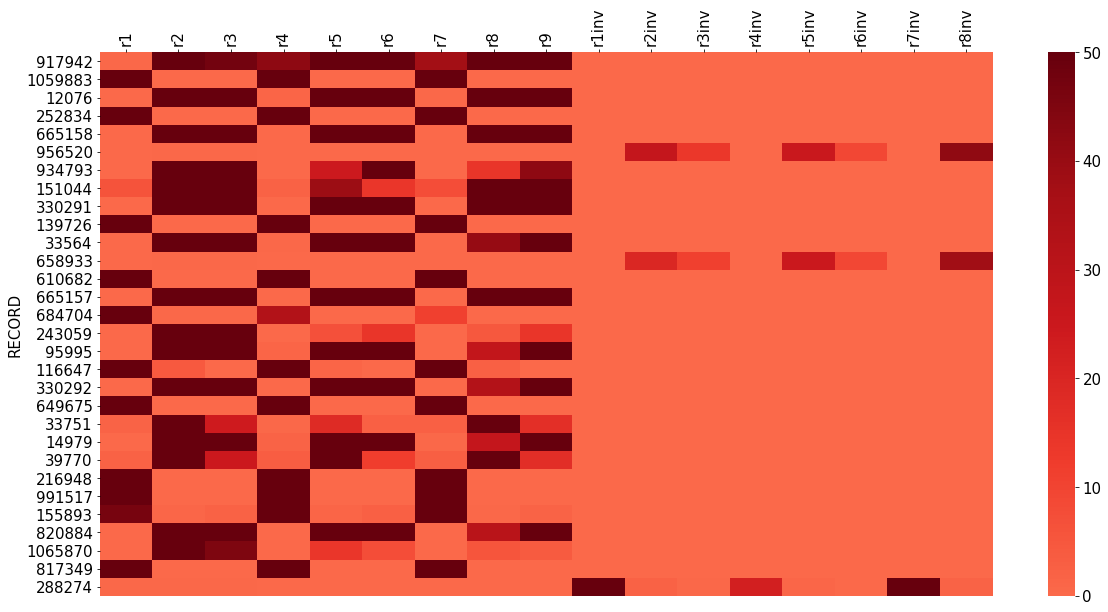

In [162]:
# Use heatmaps to see which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

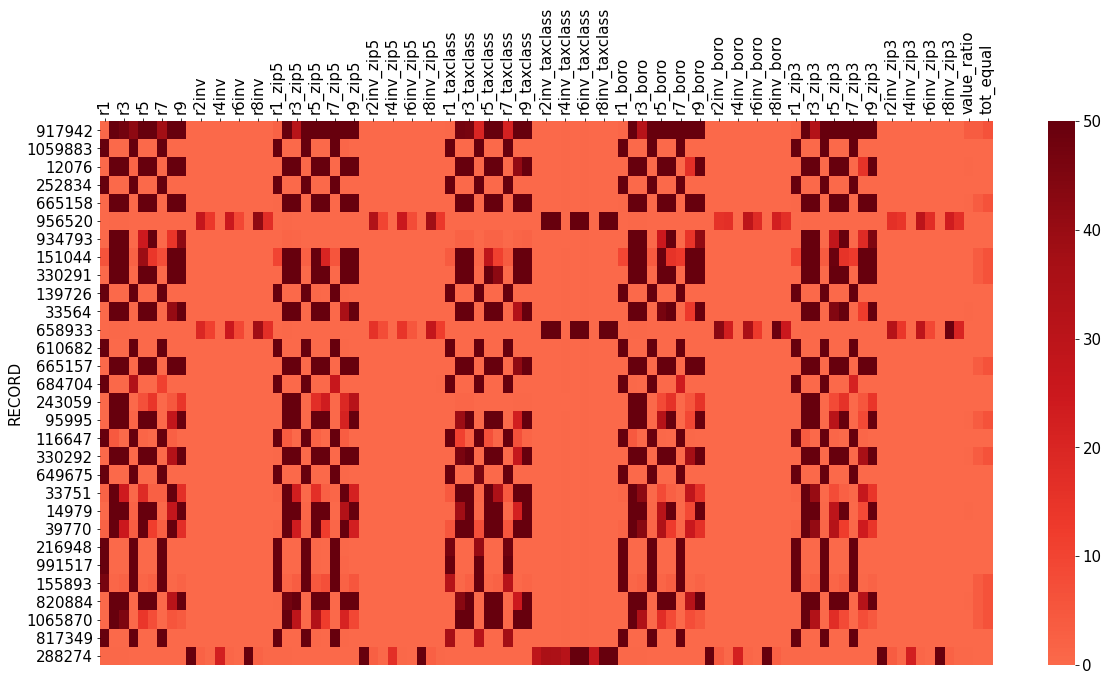

In [163]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [164]:
top_records_df = pd.DataFrame(top_records)

In [165]:
# Write out the top n record numbers
top_records_df.to_csv('top_n_record_numbers.csv', index=False)

In [97]:
# # One way is to run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores
# # Use this cell to compare the result of a changed algorithm to that of the baseline model

# top_records_previous = pd.read_csv('top_n_record_numbers.csv')
# print(top_records_df.head())
# print(top_records_previous.head())
# num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
# percent_common = 100*num_common/ntop
# percent_common

In [114]:
print('Duration: ', datetime.now() - start_time)

Duration:  19:53:33.061158
